In [2]:
import pandas as pd
import numpy as np

from numpy import array

import matplotlib.pyplot as plt

import statsmodels.api as sm

import numpy.ma as ma

In [3]:
def find_c0(dat, aa, C26_col, C29_col, C31_col):
  mat = np.empty((3,3), float)
  k = 2*np.pi/10.4
  n = array([26, 29, 31])
  mat[0:3, 0] = 1
  mat[0:3, 1] = np.sin(n*k)
  mat[0:3, 2] = np.cos(n*k)
  mat[0, 1:3] = mat[0, 1:3]*aa[0]
  mat[1, 1:3] = mat[1, 1:3]*aa[1]
  mat[2, 1:3] = mat[2, 1:3]*aa[2]
  inv_mat = np.linalg.inv(mat)
  c0A1A2 = array(np.matmul(dat[[C26_col, C29_col, C31_col]], np.transpose(inv_mat))).astype(float)
  c0Aphi = c0A1A2
  c0Aphi[:,0] = c0A1A2[:,0]
  c0Aphi[:,1] = np.sqrt(c0A1A2[:,1]**2 + c0A1A2[:,2]**2)
  c0Aphi[:,2] <- np.sign(c0A1A2[:,2]) * np.arccos(c0A1A2[:,1]/c0Aphi[:,1])
  return c0Aphi[:,0]

In [4]:
training_data_name = "tiling"

In [5]:
# genome_df_chrV = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/yeast_chrV_1bpresolution_subsequence50.csv")

In [6]:
genome_df_chrV = pd.read_csv(f"/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/ir_lstm_cn_tiling_yeast_chrV_1bpresolution_subsequence50_smoothC0_10_11.csv")

In [7]:
cn_avg_pred_df = pd.read_csv(f"/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/ir_lstm_cn_{training_data_name}_yeast_chrV_1bpresolution_subsequence50_predictions.csv")

In [8]:
genome_df_chrV = pd.concat([genome_df_chrV, cn_avg_pred_df], axis=1)

In [9]:
pred_C26 = array(genome_df_chrV["n=26"])
pred_C29 = array(genome_df_chrV["n=29"])
pred_C31 = array(genome_df_chrV["n=31"])

pred_C26_rev_comp = array(genome_df_chrV["n=26_rev_comp"])
pred_C29_rev_comp = array(genome_df_chrV["n=29_rev_comp"])
pred_C31_rev_comp = array(genome_df_chrV["n=31_rev_comp"])

pred_C0 = array(genome_df_chrV["C0"])

aa1 = [1,1,1]
aa2 = [1, 1/0.82, 1/0.7]
aa3 = [1, 0.72, 1.06]
aa4 = [1, 1/0.886, 1/0.81]

In [10]:
# Linear interpolation:
1 - (1-0.81)*(29-26)/(31-26)

0.886

In [11]:
# cycle6 = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/cycle6.txt",delimiter = ",")

In [12]:
# j=0
# matched_pairs = []
# for i, seq in enumerate(cycle6.Sequence):
#     cur_iter = 0
#     while genome_df_chrV.sequence[j+cur_iter] != seq:
#         cur_iter += 1
#         if cur_iter > 200:
#             break
#     if cur_iter > 200:
#         continue
#     j += cur_iter
#     matched_pairs.append((i,j))

In [13]:
# genome_df_chrV["C0_orig"] = np.nan
# genome_df_chrV["C26_raw"] = np.nan
# genome_df_chrV["C29_raw"] = np.nan
# genome_df_chrV["C31_raw"] = np.nan

In [14]:
# for (i, j) in matched_pairs:
#     if genome_df_chrV["sequence"].iloc[j] != cycle6["Sequence"].iloc[i]:
#         print("Error!")
#         break
#     genome_df_chrV.iloc[j, genome_df_chrV.columns.get_loc("C0_orig")] = cycle6["C0"].iloc[i]
#     genome_df_chrV.iloc[j, genome_df_chrV.columns.get_loc("C26_raw")] = cycle6["n=26"].iloc[i]
#     genome_df_chrV.iloc[j, genome_df_chrV.columns.get_loc("C29_raw")] = cycle6["n=29"].iloc[i]
#     genome_df_chrV.iloc[j, genome_df_chrV.columns.get_loc("C31_raw")] = cycle6["n=31"].iloc[i]

In [15]:
def smooth_cn(pred_cn, k):
    if k%2 == 0:
        # even
        # C(n,k)=(C(n-k/2)+C(n+k/2))/2k+(C(n-k+1)+C(n-k+2)+,…,+C(n+k-1)/k
        half_window_size = k//2
        # ret = []
        # for i in range(half_window_size, len(pred_cn)-half_window_size):
        #     weighted_endpoints = (pred_cn[i-half_window_size] + pred_cn[i+half_window_size])/(2*k)
        #     weighted_inner = sum(pred_cn[(i-half_window_size+1):(i+half_window_size-1)])/k
        #     ret.append(weighted_endpoints + weighted_inner)
        ret = [(pred_cn[i-half_window_size] + pred_cn[i+half_window_size])/(2*k) + 
               sum(pred_cn[(i-half_window_size+1):(i+half_window_size)])/k for i in range(half_window_size, len(pred_cn)-half_window_size)]
        for _ in range(half_window_size):
            ret.append(np.nan)
            ret.insert(0, np.nan)
        return ret
    elif (k+1)%2 == 0:
        # odd
        half_window_size = (k-1)//2
        ret = [np.mean(pred_cn[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,len(pred_cn)-half_window_size)]
        for _ in range(half_window_size):
            ret.append(np.nan)
            ret.insert(0, np.nan)
        return ret
    else:
        #nonint
        print("Implement using an average of closest two integer k values.")
        pass

In [16]:
C26_C29_corr = []
C26_C31_corr = []
C29_C31_corr = []

C26_C26_rev_comp_corr = []
C29_C29_rev_comp_corr = []
C31_C31_rev_comp_corr = []

# half_window_size_list = range(1,11)
# window_size_array = array(half_window_size_list)*2 + 1
window_size_array = array(list(range(2,23)))
# window_size_array = array(list(range(7,13)))
half_window_size_list = list(window_size_array/2)
smooth_cn_df = pd.DataFrame(columns=["smooth_" + str(i) + "bp_" + j for i in window_size_array for j in ["C26", "C29", "C31", "C01", "C02"]])

# for half_window_size in half_window_size_list:
for k in window_size_array:
    # smooth_C26 = [np.mean(pred_C26[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)]
    # smooth_C29 = [np.mean(pred_C29[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)]
    # smooth_C31 = [np.mean(pred_C31[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)]

    # smooth_C26_rev_comp = [np.mean(pred_C26_rev_comp[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)]
    # smooth_C29_rev_comp = [np.mean(pred_C29_rev_comp[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)]
    # smooth_C31_rev_comp = [np.mean(pred_C31_rev_comp[(i-half_window_size):(i+half_window_size+1)]) for i in range(half_window_size,genome_df_chrV.shape[0]-half_window_size)]

    smooth_C26 = smooth_cn(pred_C26, k)
    smooth_C29 = smooth_cn(pred_C29, k)
    smooth_C31 = smooth_cn(pred_C31, k)

    smooth_C26_rev_comp = smooth_cn(pred_C26_rev_comp, k)
    smooth_C29_rev_comp = smooth_cn(pred_C29_rev_comp, k)
    smooth_C31_rev_comp = smooth_cn(pred_C31_rev_comp, k)

   

    # temp_smooth_df_corr = pd.DataFrame([smooth_C26, smooth_C29, smooth_C31, 
    #                                     smooth_C26_rev_comp, smooth_C29_rev_comp, smooth_C31_rev_comp]).corr()

    # C26_C29_corr.append(np.corrcoef(smooth_C26, smooth_C29)[0,1])
    # C26_C31_corr.append(np.corrcoef(smooth_C26, smooth_C31)[0,1])
    # C29_C31_corr.append(np.corrcoef(smooth_C29, smooth_C31)[0,1])

    # C26_C26_rev_comp_corr.append(np.corrcoef(smooth_C26, smooth_C26_rev_comp)[0,1])
    # C29_C29_rev_comp_corr.append(np.corrcoef(smooth_C29, smooth_C29_rev_comp)[0,1])
    # C31_C31_rev_comp_corr.append(np.corrcoef(smooth_C31, smooth_C31_rev_comp)[0,1])

    C26_C29_corr.append(ma.corrcoef(ma.masked_invalid(smooth_C26), ma.masked_invalid(smooth_C29))[0,1])
    C26_C31_corr.append(ma.corrcoef(ma.masked_invalid(smooth_C26), ma.masked_invalid(smooth_C31))[0,1])
    C29_C31_corr.append(ma.corrcoef(ma.masked_invalid(smooth_C29), ma.masked_invalid(smooth_C31))[0,1])

    C26_C26_rev_comp_corr.append(ma.corrcoef(ma.masked_invalid(smooth_C26), ma.masked_invalid(smooth_C26_rev_comp))[0,1])
    C29_C29_rev_comp_corr.append(ma.corrcoef(ma.masked_invalid(smooth_C29), ma.masked_invalid(smooth_C29_rev_comp))[0,1])
    C31_C31_rev_comp_corr.append(ma.corrcoef(ma.masked_invalid(smooth_C31), ma.masked_invalid(smooth_C31_rev_comp))[0,1])
    

    # for i in range(half_window_size):
    #     smooth_C26.append(np.nan)
    #     smooth_C26.insert(0, np.nan)
    #     smooth_C29.append(np.nan)
    #     smooth_C29.insert(0, np.nan)
    #     smooth_C31.append(np.nan)
    #     smooth_C31.insert(0, np.nan)

    #     smooth_C26_rev_comp.append(np.nan)
    #     smooth_C26_rev_comp.insert(0, np.nan)
    #     smooth_C29_rev_comp.append(np.nan)
    #     smooth_C29_rev_comp.insert(0, np.nan)
    #     smooth_C31_rev_comp.append(np.nan)
    #     smooth_C31_rev_comp.insert(0, np.nan)

    # C26_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C26"
    # C29_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C29"
    # C31_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C31"

    # C26_rev_comp_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C26_rev_comp"
    # C29_rev_comp_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C29_rev_comp"
    # C31_rev_comp_col = "smooth_" + str(half_window_size*2 + 1) + "bp_C31_rev_comp"

    C26_col = "smooth_" + str(k) + "bp_C26"
    C29_col = "smooth_" + str(k) + "bp_C29"
    C31_col = "smooth_" + str(k) + "bp_C31"

    C26_rev_comp_col = "smooth_" + str(k) + "bp_C26_rev_comp"
    C29_rev_comp_col = "smooth_" + str(k) + "bp_C29_rev_comp"
    C31_rev_comp_col = "smooth_" + str(k) + "bp_C31_rev_comp"

    smooth_cn_df[C26_col] = smooth_C26
    smooth_cn_df[C29_col] = smooth_C29
    smooth_cn_df[C31_col] = smooth_C31

    smooth_cn_df[C26_rev_comp_col] = smooth_C26_rev_comp
    smooth_cn_df[C29_rev_comp_col] = smooth_C29_rev_comp
    smooth_cn_df[C31_rev_comp_col] = smooth_C31_rev_comp

    # smooth_C01 = find_c0(smooth_cn_df, aa1, C26_col, C29_col, C31_col)
    # smooth_C02 = find_c0(smooth_cn_df, aa2, C26_col, C29_col, C31_col)
    # smooth_cn_df["smooth_" + str(half_window_size*2 + 1) + "bp_C01"] = smooth_C01
    # smooth_cn_df["smooth_" + str(half_window_size*2 + 1) + "bp_C02"] = smooth_C02

    # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C26"] = pred_C26 - array(smooth_C26, dtype=float)
    # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C29"] = pred_C29 - array(smooth_C29, dtype=float)
    # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C31"] = pred_C31 - array(smooth_C31, dtype=float)

    # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C01"] = pred_C0 - smooth_C01
    # smooth_cn_df["detrended_smooth_" + str(half_window_size*2 + 1) + "bp_C02"] = pred_C0 - smooth_C02
    

/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_70330/2657869057.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df[C26_rev_comp_col] = smooth_C26_rev_comp
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_70330/2657869057.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df[C29_rev_comp_col] = smooth_C29_rev_comp
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_70330/2657869057.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

In [17]:
genome_df_chrV = pd.concat([genome_df_chrV, smooth_cn_df], axis=1)

In [18]:
# C26_corr = [genome_df_chrV[["C26_raw", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array]
# C29_corr = [genome_df_chrV[["C29_raw", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array]
# C31_corr = [genome_df_chrV[["C31_raw", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array]

# C26_C0_corr = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array]
# C29_C0_corr = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array]
# C31_C0_corr = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array]

# C01_C0_corr = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C01"]].corr().values[0,1] for i in window_size_array]
# C02_C0_corr = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C02"]].corr().values[0,1] for i in window_size_array]

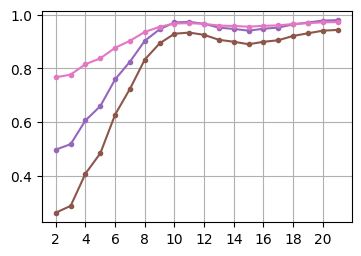

In [31]:
plt.figure(figsize=(4,2.75))

plt.plot(window_size_array[:20], C26_C29_corr[:20], marker=".", label="Smooth C26 and Smooth C29", color="C4")
plt.plot(window_size_array[:20], C26_C31_corr[:20], marker=".", label="Smooth C26 and Smooth C31", color="C5")
plt.plot(window_size_array[:20], C29_C31_corr[:20], marker=".", label="Smooth C29 and Smooth C31", color="C6")

# plt.plot(window_size_array, C26_C26_rev_comp_corr, marker="o", label="Smooth C26 and Smooth C26 reverse complement", color="C0", linestyle="dashdot")
# plt.plot(window_size_array, C29_C29_rev_comp_corr, marker="o", label="Smooth C29 and Smooth C29 reverse complement", color="C1", linestyle="dashdot")
# plt.plot(window_size_array, C31_C31_rev_comp_corr, marker="o", label="Smooth C31 and Smooth C31 reverse complement", color="C2", linestyle="dashdot")


# plt.legend()
# plt.xlabel("Window Size")
# plt.ylabel("Correlation")
plt.xticks(window_size_array[range(0,20,2)])
plt.grid()
plt.show()

In [20]:
# plt.plot(window_size_array, C26_corr, marker="o", label="Smooth C26 and Raw C26")
# plt.plot(window_size_array, C29_corr, marker="o", label="Smooth C29 and Raw C29")
# plt.plot(window_size_array, C31_corr, marker="o", label="Smooth C31 and Raw C31")
# plt.legend()
# plt.xlabel("Window Size")
# plt.ylabel("Correlation")
# plt.xticks(window_size_array)
# plt.grid()
# plt.show()

In [21]:
# plt.plot(window_size_array, C26_C0_corr, marker="o", label="Smooth C26 and Original C0")
# plt.plot(window_size_array, C29_C0_corr, marker="o", label="Smooth C29 and Original C0")
# plt.plot(window_size_array, C31_C0_corr, marker="o", label="Smooth C31 and Original C0")
# plt.legend()
# plt.xlabel("Window Size")
# plt.ylabel("Correlation")
# plt.xticks(window_size_array)
# plt.grid()
# plt.show()

In [22]:
# plt.plot(window_size_array, C01_C0_corr, marker="o", label="Smooth C0 (aa1) and Original C0")
# plt.plot(window_size_array, C02_C0_corr, marker="o", label="Smooth C0 (aa2) and Original C0")
# plt.legend()
# plt.xlabel("Window Size")
# plt.ylabel("Correlation")
# plt.xticks(window_size_array)
# plt.grid()
# plt.show()

In [23]:
# [[C26_C29_corr[i], C26_C31_corr[i], C29_C31_corr[i]] for i in range(len(C26_C29_corr))]

In [32]:
C26_C29_corr_refined = []
C26_C31_corr_refined = []
C29_C31_corr_refined = []

C26_C26_rev_comp_corr_refined = []
C29_C29_rev_comp_corr_refined = []
C31_C31_rev_comp_corr_refined = []

window_size_array_refined = array([x/10 for x in range(90, 131)])
# window_size_array_refined = array([x/10 for x in range(90, 151)])
smooth_cn_df_refined = pd.DataFrame(columns=["smooth_" + str(i) + "bp_" + j for i in window_size_array for j in ["C26", "C29", "C31"]])

for window_size in window_size_array_refined:
    # floor_window_size = int(np.floor(window_size) - ((np.floor(window_size)-1)%2))
    # ceil_window_size = int(np.ceil(window_size) + ((np.ceil(window_size)-1)%2))

    floor_window_size = int(np.floor(window_size))
    ceil_window_size = int(np.ceil(window_size))

    cur_C26_floor = smooth_cn_df[f"smooth_{floor_window_size}bp_C26"]
    cur_C26_ceil = smooth_cn_df[f"smooth_{ceil_window_size}bp_C26"]
    cur_C29_floor = smooth_cn_df[f"smooth_{floor_window_size}bp_C29"]
    cur_C29_ceil = smooth_cn_df[f"smooth_{ceil_window_size}bp_C29"]
    cur_C31_floor = smooth_cn_df[f"smooth_{floor_window_size}bp_C31"]
    cur_C31_ceil = smooth_cn_df[f"smooth_{ceil_window_size}bp_C31"]

    cur_C26_floor_rev_comp = smooth_cn_df[f"smooth_{floor_window_size}bp_C26_rev_comp"]
    cur_C26_ceil_rev_comp = smooth_cn_df[f"smooth_{ceil_window_size}bp_C26_rev_comp"]
    cur_C29_floor_rev_comp = smooth_cn_df[f"smooth_{floor_window_size}bp_C29_rev_comp"]
    cur_C29_ceil_rev_comp = smooth_cn_df[f"smooth_{ceil_window_size}bp_C29_rev_comp"]
    cur_C31_floor_rev_comp = smooth_cn_df[f"smooth_{floor_window_size}bp_C31_rev_comp"]
    cur_C31_ceil_rev_comp = smooth_cn_df[f"smooth_{ceil_window_size}bp_C31_rev_comp"]

    if floor_window_size == ceil_window_size:
        w_floor = w_ceil = 1
    else:
        w_floor = 1/(window_size-floor_window_size)
        w_ceil = 1/(ceil_window_size-window_size)

    smooth_C26 = array((cur_C26_floor*w_floor + cur_C26_ceil*w_ceil)/(w_floor + w_ceil))
    smooth_C29 = array((cur_C29_floor*w_floor + cur_C29_ceil*w_ceil)/(w_floor + w_ceil))
    smooth_C31 = array((cur_C31_floor*w_floor + cur_C31_ceil*w_ceil)/(w_floor + w_ceil))

    smooth_C26_rev_comp = array((cur_C26_floor_rev_comp*w_floor + cur_C26_ceil_rev_comp*w_ceil)/(w_floor + w_ceil))
    smooth_C29_rev_comp = array((cur_C29_floor_rev_comp*w_floor + cur_C29_ceil_rev_comp*w_ceil)/(w_floor + w_ceil))
    smooth_C31_rev_comp = array((cur_C31_floor_rev_comp*w_floor + cur_C31_ceil_rev_comp*w_ceil)/(w_floor + w_ceil))

    # C26_C29_corr_refined.append(np.corrcoef(smooth_C26[((ceil_window_size-1)//2):(len(smooth_C26) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C29[((ceil_window_size-1)//2):(len(smooth_C29) - ((ceil_window_size-1)//2))])[0,1])
    # C26_C31_corr_refined.append(np.corrcoef(smooth_C26[((ceil_window_size-1)//2):(len(smooth_C26) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C31[((ceil_window_size-1)//2):(len(smooth_C31) - ((ceil_window_size-1)//2))])[0,1])
    # C29_C31_corr_refined.append(np.corrcoef(smooth_C29[((ceil_window_size-1)//2):(len(smooth_C29) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C31[((ceil_window_size-1)//2):(len(smooth_C31) - ((ceil_window_size-1)//2))])[0,1])

    # C26_C26_rev_comp_corr_refined.append(np.corrcoef(smooth_C26[((ceil_window_size-1)//2):(len(smooth_C26) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C26_rev_comp[((ceil_window_size-1)//2):(len(smooth_C26_rev_comp) - ((ceil_window_size-1)//2))])[0,1])
    # C29_C29_rev_comp_corr_refined.append(np.corrcoef(smooth_C29[((ceil_window_size-1)//2):(len(smooth_C29) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C29_rev_comp[((ceil_window_size-1)//2):(len(smooth_C29_rev_comp) - ((ceil_window_size-1)//2))])[0,1])
    # C31_C31_rev_comp_corr_refined.append(np.corrcoef(smooth_C31[((ceil_window_size-1)//2):(len(smooth_C31) - ((ceil_window_size-1)//2))], 
    #                                         smooth_C31_rev_comp[((ceil_window_size-1)//2):(len(smooth_C31_rev_comp) - ((ceil_window_size-1)//2))])[0,1])
    

    C26_C29_corr_refined.append(ma.corrcoef(ma.masked_invalid(smooth_C26), ma.masked_invalid(smooth_C29))[0,1])
    C26_C31_corr_refined.append(ma.corrcoef(ma.masked_invalid(smooth_C26), ma.masked_invalid(smooth_C31))[0,1])
    C29_C31_corr_refined.append(ma.corrcoef(ma.masked_invalid(smooth_C29), ma.masked_invalid(smooth_C31))[0,1])

    C26_C26_rev_comp_corr_refined.append(ma.corrcoef(ma.masked_invalid(smooth_C26), ma.masked_invalid(smooth_C26_rev_comp))[0,1])
    C29_C29_rev_comp_corr_refined.append(ma.corrcoef(ma.masked_invalid(smooth_C29), ma.masked_invalid(smooth_C29_rev_comp))[0,1])
    C31_C31_rev_comp_corr_refined.append(ma.corrcoef(ma.masked_invalid(smooth_C31), ma.masked_invalid(smooth_C31_rev_comp))[0,1])
    
    C26_col = "smooth_" + str(window_size) + "bp_C26"
    C29_col = "smooth_" + str(window_size) + "bp_C29"
    C31_col = "smooth_" + str(window_size) + "bp_C31"

    C26_col_rev_comp = "smooth_" + str(window_size) + "bp_C26_rev_comp"
    C29_col_rev_comp = "smooth_" + str(window_size) + "bp_C29_rev_comp"
    C31_col_rev_comp = "smooth_" + str(window_size) + "bp_C31_rev_comp"

    smooth_cn_df_refined[C26_col] = smooth_C26
    smooth_cn_df_refined[C29_col] = smooth_C29
    smooth_cn_df_refined[C31_col] = smooth_C31

    smooth_cn_df_refined[C26_col_rev_comp] = smooth_C26_rev_comp
    smooth_cn_df_refined[C29_col_rev_comp] = smooth_C29_rev_comp
    smooth_cn_df_refined[C31_col_rev_comp] = smooth_C31_rev_comp

    # smooth_cn_mean = smooth_cn_df_refined[[C26_col, C29_col, C31_col]].mean(axis=1)
    # smooth_cn_mean2 = smooth_cn_df_refined[[C26_col, C31_col]].mean(axis=1)
    # C31_weight = 0.8
    # smooth_cn_mean3 = ((smooth_cn_df_refined[C26_col] + C31_weight*smooth_cn_df_refined[C31_col])/(1+C31_weight))[5:-5]

    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean"] = smooth_cn_mean
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean2"] = smooth_cn_mean2
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_cn_mean3"] = smooth_cn_mean3

    # smooth_C01 = find_c0(smooth_cn_df_refined, aa1, C26_col, C29_col, C31_col)
    # smooth_C02 = find_c0(smooth_cn_df_refined, aa2, C26_col, C29_col, C31_col)
    # smooth_C03 = find_c0(smooth_cn_df_refined, aa3, C26_col, C29_col, C31_col)
    # smooth_C04 = find_c0(smooth_cn_df_refined, aa4, C26_col, C29_col, C31_col)

    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C01"] = smooth_C01
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C02"] = smooth_C02
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C03"] = smooth_C03
    # smooth_cn_df_refined["smooth_" + str(window_size) + "bp_C04"] = smooth_C04

    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C26"] = pred_C26 - array(smooth_C26, dtype=float)
    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C29"] = pred_C29 - array(smooth_C29, dtype=float)
    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C31"] = pred_C31 - array(smooth_C31, dtype=float)

    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C01"] = pred_C0 - smooth_C01
    # smooth_cn_df_refined["detrended_smooth_" + str(window_size) + "bp_C02"] = pred_C0 - smooth_C02

/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_70330/3488988746.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined[C26_col_rev_comp] = smooth_C26_rev_comp
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_70330/3488988746.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smooth_cn_df_refined[C29_col_rev_comp] = smooth_C29_rev_comp
/var/folders/_4/m5twwlnn26b0q41jgwd5jnz80000gq/T/ipykernel_70330/3488988746.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [33]:
genome_df_chrV = pd.concat([genome_df_chrV, smooth_cn_df_refined], axis=1)

In [34]:
# C26_corr_refined = [genome_df_chrV[["C26_raw", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array_refined]
# C29_corr_refined = [genome_df_chrV[["C29_raw", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array_refined]
# C31_corr_refined = [genome_df_chrV[["C31_raw", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array_refined]

# C26_C0_corr_refined = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C26"]].corr().values[0,1] for i in window_size_array_refined]
# C29_C0_corr_refined = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C29"]].corr().values[0,1] for i in window_size_array_refined]
# C31_C0_corr_refined = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C31"]].corr().values[0,1] for i in window_size_array_refined]

# C01_C0_corr_refined = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C01"]].corr().values[0,1] for i in window_size_array_refined]
# C02_C0_corr_refined = [genome_df_chrV[["C0_orig", f"smooth_{i}bp_C02"]].corr().values[0,1] for i in window_size_array_refined]

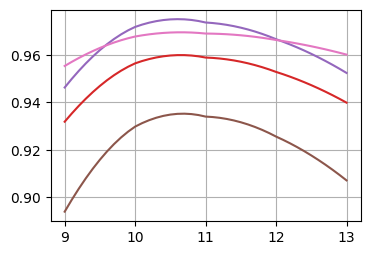

In [36]:
# plt.figure(figsize=(3,1.5))
plt.figure(figsize=(4,2.75))


# avg_correlation = [np.mean([C26_C29_corr_refined[i], C26_C31_corr_refined[i], C29_C31_corr_refined[i], C26_C26_rev_comp_corr_refined[i], 
#                             C29_C29_rev_comp_corr_refined[i], C31_C31_rev_comp_corr_refined[i]]) for i in range(len(window_size_array_refined))]

avg_correlation = [np.mean([C26_C29_corr_refined[i], C26_C31_corr_refined[i], C29_C31_corr_refined[i]]) for i in range(len(window_size_array_refined))]
alpha_val1 = 0.5
alpha_val2 = 1
plt.plot(window_size_array_refined, C26_C29_corr_refined, label="Smooth C26 and Smooth C29", color="C4")
plt.plot(window_size_array_refined, C26_C31_corr_refined, label="Smooth C26 and Smooth C31", color="C5")
plt.plot(window_size_array_refined, C29_C31_corr_refined, label="Smooth C29 and Smooth C31", color="C6")

# plt.plot(window_size_array_refined, C26_C26_rev_comp_corr_refined, label="Smooth C26 and Smooth C29", color="C0", linestyle="dashdot")
# plt.plot(window_size_array_refined, C29_C29_rev_comp_corr_refined, label="Smooth C26 and Smooth C31", color="C1", linestyle="dashdot")
# plt.plot(window_size_array_refined, C31_C31_rev_comp_corr_refined, label="Smooth C29 and Smooth C31", color="C2", linestyle="dashdot")

plt.plot(window_size_array_refined, avg_correlation, label="Mean", color="C3")
# plt.legend()
# plt.xlabel("Effective Window Size")
# plt.ylabel("Correlation")
# plt.ylim([.85, 1])
plt.grid()
plt.show()

In [38]:
pip install docopt

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b28ada9d8777eafffbe6595f2fd8faea1ec1614335a5a6246d1c4b9a5a3083e0
  Stored in directory: /Users/Brody1/Library/Caches/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
import Bio
Bio.__version__

'1.83'

/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/.venv/lib/python3.11/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/.venv/lib/python3.11/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/.venv/lib/python3.11/site-packages/matplotlib/patches.py:742: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/.venv/lib/python3.11/site-packages/matplotlib/patches.py:743: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)


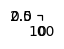

<Figure size 1400x200 with 0 Axes>

In [74]:
x = np.linspace(1, 100, 1000)
y = np.log(x)
y1 = np.sin(x)
fig = plt.figure("Line plot", figsize=(0,0))
legendFig = plt.figure("Legend plot")
ax = fig.add_subplot(111)
line1, = ax.plot(x,y, color="C4")
line2, = ax.plot(x,y, color="C5")
line3, = ax.plot(x,y, color="C6")
# line4, = ax.plot(x,y, color="C0", linestyle="dashdot")
# line5, = ax.plot(x,y, color="C1", linestyle="dashdot")
# line6, = ax.plot(x,y, color="C2", linestyle="dashdot")
line7, = ax.plot(x,y, color="C3")
# line8, = ax.plot(x,y, color="white")
# line1, = ax.plot(x, y, c="red", lw=4, linestyle="dashdot")
# line2, = ax.plot(x, y1, c="green", lw=1, linestyle="--")
# legendFig.legend([line1, line4, line2, line5, line3, line6], 
#                  ["C26", "C26 Reverse Complement",
#                   "C29", "C29 Reverse Complement",
#                   "C31", "C31 Reverse Complement"], ncol=3)
legendFig.legend([line1, line2, line3, line7], 
                 ["C26, C29", "C26, C31", "C29, C31", "Average"], ncols=2)
legendFig.set_figheight(2)
legendFig.set_figwidth(14)
legendFig.savefig('legend.png')

In [27]:
# plt.plot(window_size_array_refined, C26_corr_refined, marker="o", label="Smooth C26 and Raw C26")
# plt.plot(window_size_array_refined, C29_corr_refined, marker="o", label="Smooth C29 and Raw C29")
# plt.plot(window_size_array_refined, C31_corr_refined, marker="o", label="Smooth C31 and Raw C31")
# plt.legend()
# plt.xlabel("Effective Window Size")
# plt.ylabel("Correlation")
# plt.grid()
# plt.show()

In [28]:
# plt.plot(window_size_array_refined, C26_C0_corr_refined, marker="o", label="Smooth C26 and Original C0")
# plt.plot(window_size_array_refined, C29_C0_corr_refined, marker="o", label="Smooth C29 and Original C0")
# plt.plot(window_size_array_refined, C31_C0_corr_refined, marker="o", label="Smooth C31 and Original C0")
# plt.legend()
# plt.xlabel("Effective Window Size")
# plt.ylabel("Correlation")
# plt.grid()
# plt.show()

In [29]:
# plt.plot(window_size_array_refined, C01_C0_corr_refined, marker="o", label="Smooth C0 (aa1) and Original C0")
# plt.plot(window_size_array_refined, C02_C0_corr_refined, marker="o", label="Smooth C0 (aa2) and Original C0")
# plt.legend()
# plt.xlabel("Effective Window Size")
# plt.ylabel("Correlation")
# plt.grid()
# plt.show()

In [30]:
# plt.plot(window_size_array_refined, avg_correlation, marker="o", label="Average")
# plt.legend()
# plt.xlabel("Effective Window Size")
# plt.ylabel("Correlation")
# plt.ylim([.9, 1])
# plt.grid()
# plt.show()

In [37]:
window_size_array_refined[np.where(avg_correlation == max(avg_correlation))]

array([10.6])

In [29]:
avg_correlation

[0.9318185840155451,
 0.935276814850274,
 0.938528438972244,
 0.9415682769316783,
 0.9443915687634258,
 0.9469937794544719,
 0.9493706144309645,
 0.9515180345383564,
 0.9534322704219674,
 0.9551098362167908,
 0.9565475424575508,
 0.9575434165257258,
 0.9583753696205984,
 0.9590421293710593,
 0.9595425737620918,
 0.9598757341993207,
 0.9600407982176634,
 0.9600371118207391,
 0.9598641814394099,
 0.9595216754995514,
 0.959009425590919,
 0.9588557567454937,
 0.9586014725690911,
 0.958246130279739,
 0.957789523610634,
 0.9572315065458993,
 0.9565719937315058,
 0.9558109607936868,
 0.9549484445638007,
 0.9539845432086188,
 0.9529194162655713,
 0.9519392531394931,
 0.9508869399781412,
 0.9497626760318424,
 0.9485666916562572,
 0.9472992481373158,
 0.9459606374818407,
 0.9445511821742937,
 0.9430712349000712,
 0.9415211782358672,
 0.9399014243076919,
 0.9395626221058925,
 0.9391980975872137,
 0.938807548012461,
 0.9383909295100649,
 0.9379482029923055,
 0.9374793341911526,
 0.9369842936919387

In [32]:
# ### DNAcycP:
# DNAcycP_pred_chrV = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/predictions/chrv_1bp_cycle_norm_DNAcycP.txt", header=None)
# DNAcycP_pred_chrV = array(DNAcycP_pred_chrV)
# genome_df_chrV["DNAcycP_pred_chrV"] = DNAcycP_pred_chrV

In [33]:
# ### CycPred:
# CycPred_pred_chrV = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/predictions/cycpred_chrv_1bp.txt", header=None)
# CycPred_pred_chrV_mean = CycPred_pred_chrV.mean()
# CycPred_pred_chrV_std = CycPred_pred_chrV.std()
# CycPred_pred_chrV = (CycPred_pred_chrV-CycPred_pred_chrV_mean)/CycPred_pred_chrV_std
# CycPred_pred_chrV = array(CycPred_pred_chrV)
# genome_df_chrV["CycPred_pred_chrV"] = CycPred_pred_chrV

In [34]:
# ### DeepBend:
# DeepBend_pred_chrV = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/predictions/deepbend_chrv_1bp.txt", header=None)
# DeepBend_pred_chrV_mean = DeepBend_pred_chrV.mean()
# DeepBend_pred_chrV_std = DeepBend_pred_chrV.std()
# DeepBend_pred_chrV = (DeepBend_pred_chrV-DeepBend_pred_chrV_mean)/DeepBend_pred_chrV_std
# DeepBend_pred_chrV = array(DeepBend_pred_chrV)
# genome_df_chrV["DeepBend_pred_chrV"] = DeepBend_pred_chrV

In [35]:
# ### MIXBend:
# MIXBend_pred_chrV = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/predictions/mixbend_chrv_1bp.txt")
# MIXBend_pred_chrV_mean = MIXBend_pred_chrV.mean()
# MIXBend_pred_chrV_std = MIXBend_pred_chrV.std()
# MIXBend_pred_chrV = (MIXBend_pred_chrV-MIXBend_pred_chrV_mean)/MIXBend_pred_chrV_std
# MIXBend_pred_chrV = array(MIXBend_pred_chrV)
# genome_df_chrV["MIXBend_pred_chrV"] = MIXBend_pred_chrV

In [38]:
# # sequence_length = 50
sequence_length = 100
# # sequence_length = 147
# sequence_length = 200
# # sequence_length = 2000

# # starting_point = 0
# # starting_point = 200
# # starting_point = 34048
# # starting_point = 62614 # Solid crazy region (sequence_length=200)
# # starting_point = 107225 # Relatively flat
# # starting_point = 112147 # Discrepancy between C31 and rest
# # starting_point = 122424 # Discrepancy between C31 and rest
# # starting_point = 158803 # Discrepancy bewteen C31 and rest
# # starting_point = 192669 # Evidence of 5bp and 10bp periodicity? (sequence_length = 147)
# # starting_point=  244776 # Interesting volatility
# # starting_point = 277215 # 5bp periodicity
# # starting_point = 313465 # Discrepancy between C31 and rest
# # starting_point = 403190 # 5bp periodicity
# # starting_point = 407586 # Discrepancy between all Cn
# # starting_point = 428150 # High C0 values, 1bp volatility
# # starting_point = 465270 # High C0 values, some 5bp periodicity
# # starting_point = 465281 # somewhat abnormal 5bp periodicity
# # starting_point = 469786 # mild 1bp volatility
# # starting_point = 502770 # A High C0 value, 5bp periodicity
# # starting_point = 522942 # One big peak
# # starting_point = 560846 # 1bp volatility

# # starting_point = 43747 # Discrepancy between all Cn
# # starting_point = 175497 # Discrepancy between all Cn (in two locations)
# # starting_point = 485265 # Discrepancy between all Cn



# starting_point = 243588 # polyA "Problem Region" Medium SmoothC0

# # starting_point = 44910 # polyA/T "Problem Region" Low Smooth C0

# # starting_point = 390145 # polyA/T Problem-ish region but low smooth C0

# starting_point = 358988 # polyA/T Not Problem, steep change to low smooth C0


# # starting_point=12200 # Steep Change to large smooth C0
# # starting_point=15000 # Multiple steep changes to large smooth C0
# # starting_point=16400 # Steep Change to large values, Problem Region
# starting_point=18400 # Steep Change to large values, Problem Region
# starting_point=18600 # Multiple steep changes to large values
# starting_point=43800 # Large Value Problem Region
# starting_point=45000 # Low Value Problem Region
# starting_point=51400 # High Value Problem Region, Steep Spike Large Value
# starting_point=52400 # Steep Spike Large Value
# starting_point=53200 # Steep Spike
# starting_point=56000 # Large Value Problem Region
# starting_point=59200 # Mid Value Problem Region
# starting_point=60900 # Quick Spike, Low Value Problem-ish Region
# starting_point=61500 # Big Spike
# starting_point=61700 # High Value Problem Region
# starting_point=65200 # Problem Region
# starting_point=73400 # Problem-ish Low Value Region
# starting_point=77100 # High value Problem Region
# starting_point=85300 # Low value Problem-ish Region
# starting_point=86400 # Mid and High value Problem
# starting_point=88600 # High value Problem
# starting_point=90500 # Big Spike
# starting_point=94500 # Problem Region
# starting_point=95000 # Problem-ish Region
# starting_point=100500 # Mid Value Problem Region

# # starting_point = np.random.randint(genome_df_chrV.shape[0]-sequence_length)

# # starting_point = 250691 # Region on Slides
# starting_point = 479158 # Region for Paper?
starting_point = 479208 # Region for Paper?



# starting_point1 = 250691 # Region on Slides
# starting_point2 = 406604

# alpha_val = 0.5
# # alpha_val = 0.3
# alpha_val_2 = 0.4
# alpha_val_3 = 0.5
# alpha_val_4 = 0.5

# # ylims=[-3, 3]
ylims=[-3.5, 3.5]

# plt.figure(figsize=(12,7))

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val, color="C0")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val, color="C1")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val, color="C2")
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          genome_df_chrV["C0"][range(starting_point, starting_point + sequence_length)], label="Predicted C0", alpha=alpha_val_4)

# # plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_chrV.C0[range(starting_point, starting_point + sequence_length)]) if x is not None],
# #          [x for x in genome_df_chrV.C0[range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C0", alpha=alpha_val_2, marker="o")
# # plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_chrV.C26_raw[range(starting_point, starting_point + sequence_length)]) if x is not None],
# #          [x for x in genome_df_chrV.C26_raw[range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C26", alpha=alpha_val_3, marker="o")
# # plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_chrV.C29_raw[range(starting_point, starting_point + sequence_length)]) if x is not None],
# #          [x for x in genome_df_chrV.C29_raw[range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C29", alpha=alpha_val_3, marker="o")
# # plt.plot([list(range(starting_point, starting_point + sequence_length))[i] for i, x in enumerate(genome_df_chrV.C31_raw[range(starting_point, starting_point + sequence_length)]) if x is not None],
# #          [x for x in genome_df_chrV.C31_raw[range(starting_point, starting_point + sequence_length)] if x is not None], label="Original C31", alpha=alpha_val_3, marker="o")

# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          ((genome_df_chrV["n=26"] + genome_df_chrV["n=31"])/2)[range(starting_point, starting_point + sequence_length)], label="Predicted C26 - C31", alpha=alpha_val, color="C4")

# plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
# # plt.title("Predictions on ChrV, No Smoothing")
# plt.legend(fontsize="small")
# plt.ylim(ylims)
# plt.show()

In [39]:
starting_point

479208

In [40]:
# plt.figure(figsize=(12,7))

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_3bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_3bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_3bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df["smooth_3bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df["smooth_3bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df["smooth_3bp_cn_mean"][range(starting_point, starting_point + sequence_length)], label="Predicted Cn Mean", alpha=alpha_val)


# plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
# plt.title("Predictions on ChrV, 3bp Smoothing")
# plt.legend(fontsize="small")
# plt.ylim(ylims)
# plt.show()

In [41]:
# plt.figure(figsize=(6,3))

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26, Unsmoothed", alpha=0.3, color="C0")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29, Unsmoothed", alpha=0.3, color="C1")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31, Unsmoothed", alpha=0.3, color="C2")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_5bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_5bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_5bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df["smooth_5bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df["smooth_5bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

# plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
# # plt.title("Predictions on ChrV, 5bp Smoothing")
# plt.legend(fontsize="small")
# plt.ylim(ylims)
# plt.show()

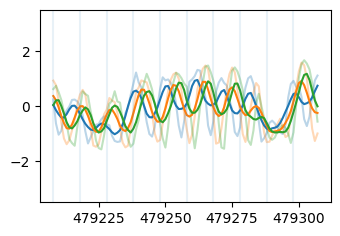

In [42]:
plt.figure(figsize=(3.75, 2.5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=0.3, color="C0")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=0.3, color="C1")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=0.3, color="C2")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=26_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=0.3, 
#          color="C0", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=29_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=0.3, 
#          color="C1", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=31_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=0.3, 
#          color="C2", linestyle="dashed")

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_7bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26, Smoothed")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_7bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29, Smoothed")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_7bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31, Smoothed")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_7bp_C26_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C26, Smoothed", 
#          color="C0", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_7bp_C29_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C29, Smoothed", 
#          color="C1", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_7bp_C31_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C31, Smoothed", 
#          color="C2", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_7bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_7bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
# plt.title("Predictions on ChrV, 7bp Smoothing")
# plt.legend(fontsize="small")
plt.ylim(ylims)
plt.locator_params(axis='x', nbins=5)
plt.show()

In [ ]:
# plt.figure(figsize=(12,7))

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26, Unsmoothed", alpha=0.3, color="C0")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29, Unsmoothed", alpha=0.3, color="C1")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31, Unsmoothed", alpha=0.3, color="C2")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_9bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_9bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_9bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df["smooth_9bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df["smooth_9bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

# plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
# plt.title("Predictions on ChrV, 9bp Smoothing")
# plt.legend(fontsize="small")
# plt.ylim(ylims)
# plt.show()

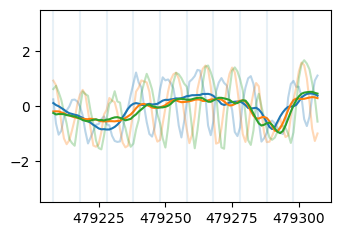

In [43]:
plt.figure(figsize=(3.75, 2.5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=0.3, color="C0")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=0.3, color="C1")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=0.3, color="C2")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=26_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=0.3, 
#          color="C0", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=29_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=0.3, 
#          color="C1", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=31_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=0.3, 
#          color="C2", linestyle="dashed")

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_11bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26, Smoothed")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_11bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29, Smoothed")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["smooth_11bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31, Smoothed")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_11bp_C26_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C26, Smoothed", 
#          color="C0", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_11bp_C29_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C29, Smoothed", 
#          color="C1", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_11bp_C31_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C31, Smoothed", 
#          color="C2", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_11bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df["smooth_11bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
# plt.title("Predictions on ChrV, 11bp Smoothing")
# plt.legend(fontsize="small")
plt.ylim(ylims)
plt.locator_params(axis='x', nbins=5)
plt.show()

In [200]:
starting_point = 0

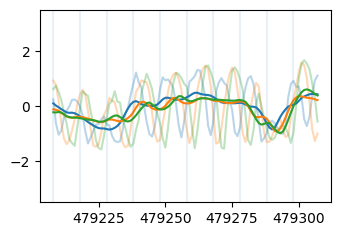

In [48]:
plt.figure(figsize=(3.75, 2.5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=0.3, color="C0")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=0.3, color="C1")
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         genome_df_chrV["n=31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=0.3, color="C2")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=26_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=0.3, 
#          color="C0", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=29_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=0.3, 
#          color="C1", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          genome_df_chrV["n=31_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=0.3, 
#          color="C2", linestyle="dashed")

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.4bp_C26"][range(starting_point, starting_point + sequence_length)])
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.4bp_C29"][range(starting_point, starting_point + sequence_length)])
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["smooth_10.4bp_C31"][range(starting_point, starting_point + sequence_length)])

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_C26_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C26, Smoothed", 
#          color="C0", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_C29_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C29, Smoothed", 
#          color="C1", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_C31_rev_comp"][range(starting_point, starting_point + sequence_length)], label="Predicted C31, Smoothed", 
#          color="C2", linestyle="dashed")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val, color="C3")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_cn_mean"][range(starting_point, starting_point + sequence_length)], label="Predicted Cn Mean", alpha=alpha_val, color="C3")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.4bp_cn_mean2"][range(starting_point, starting_point + sequence_length)], label="SmoothC0", alpha=alpha_val, color="C3")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          ((genome_df_chrV["smooth_10.4bp_C26"] + genome_df_chrV["smooth_10.4bp_C31"])/2)[range(starting_point, starting_point + sequence_length)], label="Predicted C26, C31 mean", alpha=alpha_val, color="C4")

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          DNAcycP_pred_chrV[range(starting_point, starting_point + sequence_length)], label="Predicted DNAcycP", alpha=0.8, color="C4")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          CycPred_pred_chrV[range(starting_point, starting_point + sequence_length)], label="Predicted CycPred", alpha=0.8, color="C5")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          DeepBend_pred_chrV[range(starting_point, starting_point + sequence_length)], label="Predicted DeepBend", alpha=0.8, color="C6")
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          MIXBend_pred_chrV[range(starting_point, starting_point + sequence_length)], label="Predicted MIXBend", alpha=0.8, color="C7")

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)

# plt.title("Predictions on ChrV, 10.4bp Smoothing")
# plt.legend(fontsize="small")
plt.ylim(ylims)
plt.locator_params(axis='x', nbins=5)
plt.show()
# starting_point+=200

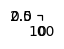

<Figure size 800x200 with 0 Axes>

In [280]:
x = np.linspace(1, 100, 1000)
y = np.log(x)
y1 = np.sin(x)
fig = plt.figure("Line plot", figsize=(0,0))
legendFig = plt.figure("Legend plot")
ax = fig.add_subplot(111)
line1, = ax.plot(x,y, color="C0")
line2, = ax.plot(x,y, color="C1")
line3, = ax.plot(x,y, color="C2")
line4, = ax.plot(x,y, color="C0", alpha=0.3)
line5, = ax.plot(x,y, color="C1", alpha=0.3)
line6, = ax.plot(x,y, color="C2", alpha=0.3)
# line7, = ax.plot(x,y, color="C3")
# line8, = ax.plot(x,y, color="white")
# line1, = ax.plot(x, y, c="red", lw=4, linestyle="dashdot")
# line2, = ax.plot(x, y1, c="green", lw=1, linestyle="--")
# legendFig.legend([line1, line4, line2, line5, line3, line6], 
#                  ["C26", "C26 Reverse Complement",
#                   "C29", "C29 Reverse Complement",
#                   "C31", "C31 Reverse Complement"], ncol=3)
legendFig.legend([line1, line2, line3, line4, line5, line6,],
                 ["Smooth C26", "Smooth C29", "Smooth C31",
                  "C26", "C29", "C31"], ncol=2)
legendFig.set_figheight(2)
legendFig.set_figwidth(8)
legendFig.savefig('legend.png')

In [202]:
# starting_point = starting_point-400

In [203]:
# plt.figure(figsize=(12,7))

# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.7bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.7bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
# plt.plot(list(range(starting_point, starting_point + sequence_length)),
#          smooth_cn_df_refined["smooth_10.7bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df_refined["smooth_10.7bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df_refined["smooth_10.7bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)
# # plt.plot(list(range(starting_point, starting_point + sequence_length)),
# #          smooth_cn_df_refined["smooth_10.7bp_cn_mean"][range(starting_point, starting_point + sequence_length)], label="Predicted Cn Mean", alpha=alpha_val)

# plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
# plt.title("Predictions on ChrV, 10.7bp Smoothing")
# plt.legend(fontsize="small")
# plt.ylim(ylims)
# plt.show()

In [204]:
starting_point

0

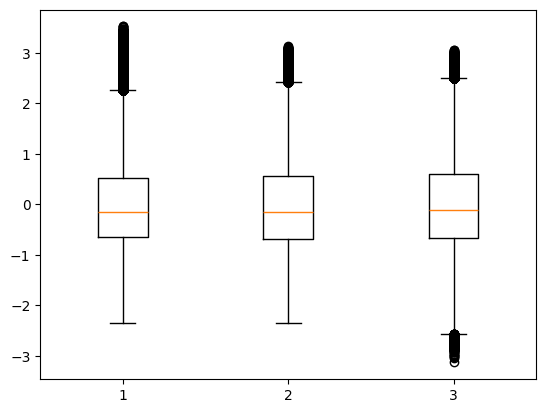

In [205]:
plt.boxplot([genome_df_chrV["n=26"], genome_df_chrV["n=29"], genome_df_chrV["n=31"]])
plt.show()

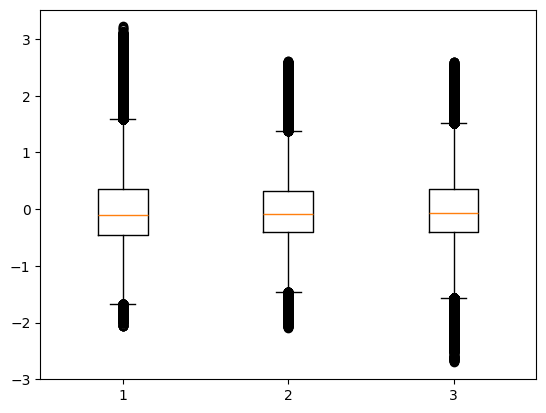

In [206]:
plt.boxplot([genome_df_chrV["smooth_10.4bp_C26"][range(5, genome_df_chrV.shape[0]-5)], genome_df_chrV["smooth_10.4bp_C29"][range(5, genome_df_chrV.shape[0]-5)], genome_df_chrV["smooth_10.4bp_C31"][range(5, genome_df_chrV.shape[0]-5)]])
plt.show()

In [207]:
import scipy

In [208]:
temp = scipy.stats.ecdf(genome_df_chrV["smooth_10.4bp_C26"][range(5, genome_df_chrV.shape[0]-5)])

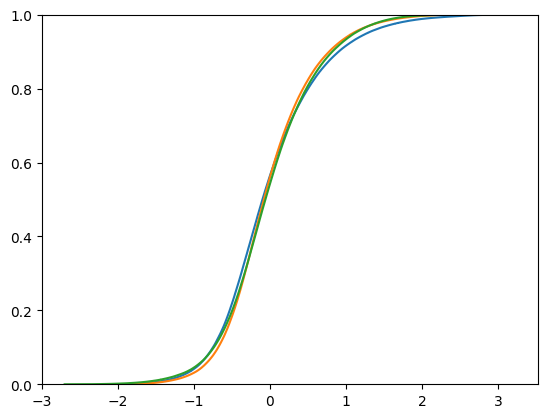

In [209]:
plt.ecdf(genome_df_chrV["smooth_10.4bp_C26"][range(5, genome_df_chrV.shape[0]-5)])
plt.ecdf(genome_df_chrV["smooth_10.4bp_C29"][range(5, genome_df_chrV.shape[0]-5)])
plt.ecdf(genome_df_chrV["smooth_10.4bp_C31"][range(5, genome_df_chrV.shape[0]-5)])
plt.show()

In [54]:
genome_df_chrV_aligned = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/yeast_chrV_nucleosome_alignment_window_size200.csv")

In [55]:
genome_df_chrV_aligned

,sequence,distance_to_nucleosome,chrID,nucleosome_center,position
0,CCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTT...,-200,chrV,233,8
1,CAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTA...,-199,chrV,233,9
2,AAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTAC...,-198,chrV,233,10
3,AGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACT...,-197,chrV,233,11
4,GCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTA...,-196,chrV,233,12
...,...,...,...,...,...
1276795,AAGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACA...,195,chrV,576556,576726
1276796,AGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAG...,196,chrV,576556,576727
1276797,GGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGG...,197,chrV,576556,576728
1276798,GTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGGG...,198,chrV,576556,576729


In [56]:
genome_df_chrV_aligned["n=26"] = genome_df_chrV.loc[genome_df_chrV_aligned["position"], "n=26"].values
genome_df_chrV_aligned["n=29"] = genome_df_chrV.loc[genome_df_chrV_aligned["position"], "n=29"].values
genome_df_chrV_aligned["n=31"] = genome_df_chrV.loc[genome_df_chrV_aligned["position"], "n=31"].values

genome_df_chrV_aligned["n=26_rev_comp"] = genome_df_chrV.loc[genome_df_chrV_aligned["position"], "n=26_rev_comp"].values
genome_df_chrV_aligned["n=29_rev_comp"] = genome_df_chrV.loc[genome_df_chrV_aligned["position"], "n=29_rev_comp"].values
genome_df_chrV_aligned["n=31_rev_comp"] = genome_df_chrV.loc[genome_df_chrV_aligned["position"], "n=31_rev_comp"].values

genome_df_chrV_aligned["smoothC0"] = genome_df_chrV.loc[genome_df_chrV_aligned["position"], "smoothC0"].values

In [57]:
genome_df_chrV_aligned

,sequence,distance_to_nucleosome,chrID,nucleosome_center,position,n=26,n=29,n=31,n=26_rev_comp,n=29_rev_comp,n=31_rev_comp,smoothC0
0,CCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTT...,-200,chrV,233,8,-0.194927,-0.469367,-0.554537,-0.160897,-0.001296,-0.372589,-0.367240
1,CAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTA...,-199,chrV,233,9,-0.277341,-0.466282,-0.558129,-0.220960,-0.203360,-0.572820,-0.356558
2,AAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTAC...,-198,chrV,233,10,-0.320842,-0.207001,-0.422720,-0.175286,-0.645260,-0.808290,-0.343501
3,AGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACT...,-197,chrV,233,11,-0.424420,-0.134078,-0.229734,-0.345943,-0.814332,-0.667328,-0.320116
4,GCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTA...,-196,chrV,233,12,-0.619899,0.154437,0.097751,-0.364871,-0.846146,-0.494482,-0.280981
...,...,...,...,...,...,...,...,...,...,...,...,...
1276795,AAGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACA...,195,chrV,576556,576726,-0.364871,-0.846146,-0.494482,-0.619899,0.154437,0.097751,-0.280981
1276796,AGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAG...,196,chrV,576556,576727,-0.345943,-0.814332,-0.667328,-0.424420,-0.134078,-0.229734,-0.320116
1276797,GGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGG...,197,chrV,576556,576728,-0.175286,-0.645260,-0.808290,-0.320842,-0.207001,-0.422720,-0.343501
1276798,GTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGGG...,198,chrV,576556,576729,-0.220960,-0.203360,-0.572820,-0.277341,-0.466282,-0.558129,-0.356558


In [58]:
genome_df_chrV_aligned = pd.concat([genome_df_chrV_aligned, smooth_cn_df.loc[genome_df_chrV_aligned["position"]].reset_index()], axis=1)

In [59]:
genome_df_chrV_aligned

,sequence,distance_to_nucleosome,chrID,nucleosome_center,position,n=26,n=29,n=31,n=26_rev_comp,n=29_rev_comp,...,smooth_15bp_C31_rev_comp,smooth_17bp_C26_rev_comp,smooth_17bp_C29_rev_comp,smooth_17bp_C31_rev_comp,smooth_19bp_C26_rev_comp,smooth_19bp_C29_rev_comp,smooth_19bp_C31_rev_comp,smooth_21bp_C26_rev_comp,smooth_21bp_C29_rev_comp,smooth_21bp_C31_rev_comp
0,CCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTT...,-200,chrV,233,8,-0.194927,-0.469367,-0.554537,-0.160897,-0.001296,...,-0.235306,-0.497810,-0.219062,-0.193245,NaN,NaN,NaN,NaN,NaN,NaN
1,CAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTA...,-199,chrV,233,9,-0.277341,-0.466282,-0.558129,-0.220960,-0.203360,...,-0.173618,-0.457443,-0.130569,-0.126954,-0.384740,-0.065145,-0.104393,NaN,NaN,NaN
2,AAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTAC...,-198,chrV,233,10,-0.320842,-0.207001,-0.422720,-0.175286,-0.645260,...,-0.103775,-0.366465,-0.034438,-0.076621,-0.302195,-0.001279,-0.091988,-0.232498,0.001538,-0.147571
3,AGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACT...,-197,chrV,233,11,-0.424420,-0.134078,-0.229734,-0.345943,-0.814332,...,-0.041239,-0.274830,0.037795,-0.067422,-0.200122,0.036032,-0.127268,-0.149409,0.000931,-0.162384
4,GCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTA...,-196,chrV,233,12,-0.619899,0.154437,0.097751,-0.364871,-0.846146,...,-0.056300,-0.160865,0.090490,-0.102007,-0.108842,0.036124,-0.147815,-0.069046,-0.023887,-0.141767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276795,AAGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACA...,195,chrV,576556,576726,-0.364871,-0.846146,-0.494482,-0.619899,0.154437,...,-0.331569,-0.147773,-0.329996,-0.315571,-0.114301,-0.257927,-0.265977,-0.101318,-0.186589,-0.212301
1276796,AGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAG...,196,chrV,576556,576727,-0.345943,-0.814332,-0.667328,-0.424420,-0.134078,...,-0.302802,-0.229981,-0.403228,-0.335193,-0.171268,-0.342148,-0.328455,-0.133055,-0.285836,-0.287296
1276797,GGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGG...,197,chrV,576556,576728,-0.175286,-0.645260,-0.808290,-0.320842,-0.207001,...,-0.270578,-0.306970,-0.436412,-0.318703,-0.238532,-0.418781,-0.351471,-0.189869,-0.370562,-0.339999
1276798,GTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGGG...,198,chrV,576556,576729,-0.220960,-0.203360,-0.572820,-0.277341,-0.466282,...,-0.265139,-0.384357,-0.459847,-0.296372,-0.313245,-0.457895,-0.332489,-0.260602,-0.441600,-0.350287


In [60]:
genome_df_chrV_aligned = pd.concat([genome_df_chrV_aligned, smooth_cn_df_refined.loc[genome_df_chrV_aligned["position"]].reset_index()], axis=1)

In [61]:
genome_df_chrV_dist_nuc_grouped = genome_df_chrV_aligned.groupby("distance_to_nucleosome").mean(numeric_only=True)

In [62]:
xlims_aligned=[-200, 200]
ylims_aligned1=[-0.4, 0.4]
alpha_val_aligned = 0.5

In [251]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["n=26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["n=29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["n=31"], label="Predicted C31", alpha=alpha_val_aligned)

# # plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# # plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# # plt.title("ChrV Aligned at Nucleosome Centers, No Smoothing")
# # plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [252]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_3bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_3bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_3bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 3bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [253]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_5bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_5bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_5bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 5bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [254]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_7bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_7bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_7bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 7bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [255]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_9bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_9bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_9bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 9bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [256]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_11bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_11bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_11bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 11bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [257]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.2bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.2bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.2bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 10.2bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [258]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.3bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.3bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.3bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 10.3bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [259]:
# plt.figure(figsize=(6,4))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# # plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_cn_mean_2"], label="Predicted Cn Mean 2", alpha=alpha_val_aligned)

# # plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# # plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# # plt.title("ChrV Aligned at Nucleosome Centers, 10.4bp Smoothing")
# # plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [260]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.5bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.5bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.5bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 10.5bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [261]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 10.7bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned1)
# plt.show()

In [63]:
ylims_aligned2=[-0.1, 0.1]

In [263]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["C0"], label="Predicted C0", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, No Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned2)
# plt.show()

In [264]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_3bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# # plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_3bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 3bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned2)
# plt.show()

In [265]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_5bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# # plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_5bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 5bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned2)
# plt.show()

In [266]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_7bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# # plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_7bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 7bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned2)
# plt.show()

In [267]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_9bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# # plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_9bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 9bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned2)
# plt.show()

In [268]:
# plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_11bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# # plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_11bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

# plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 11bp Smoothing")
# plt.legend(fontsize="small")
# plt.xlim(xlims_aligned)
# plt.ylim(ylims_aligned2)
# plt.show()

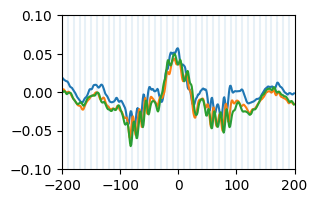

In [72]:
plt.figure(figsize=(3,2))

plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C26"], label="Predicted C26")
plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C29"], label="Predicted C29")
plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C31"], label="Predicted C31")

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C26_rev_comp"], label="Predicted C26",
#          color="C0", linestyle="dashed")
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C29_rev_comp"], label="Predicted C29",
#          color="C1", linestyle="dashed")
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C31_rev_comp"], label="Predicted C31",
#          color="C2", linestyle="dashed")


# plt.plot(genome_df_chrV_dist_nuc_grouped["smoothC0"], label="SmoothC0", color="C3")

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C03"], label="Predicted C0 (aa3)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C04"], label="Predicted C0 (aa4)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_cn_mean"], label="Predicted Cn Mean", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_cn_mean2"], label="SmoothC0", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_cn_mean3"], label="Predicted Cn Mean 3", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1]+1, alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 10.4bp Smoothing")
# plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned2)
plt.show()

In [238]:
genome_df_chrV_dist_nuc_grouped

,nucleosome_center,position,n=26,n=29,n=31,n=26_rev_comp,n=29_rev_comp,n=31_rev_comp,C0,index,...,smooth_12.9bp_C31,smooth_12.9bp_C26_rev_comp,smooth_12.9bp_C29_rev_comp,smooth_12.9bp_C31_rev_comp,smooth_13.0bp_C26,smooth_13.0bp_C29,smooth_13.0bp_C31,smooth_13.0bp_C26_rev_comp,smooth_13.0bp_C29_rev_comp,smooth_13.0bp_C31_rev_comp
distance_to_nucleosome,,,,,,,,,,,,,,,,,,,,,
-200,287750.876566,287525.876566,0.025062,-0.033171,-0.022880,-0.000395,0.050811,0.026162,0.007363,287525.876566,...,0.004251,0.020583,-0.003378,-0.008883,0.014652,0.010246,0.004390,0.020590,-0.003688,-0.009110
-199,287750.876566,287526.876566,0.048224,-0.030075,-0.029633,0.025622,0.054271,0.007802,0.018420,287526.876566,...,0.008099,0.017511,-0.003224,-0.004960,0.012324,0.008749,0.008376,0.017391,-0.003490,-0.005032
-198,287750.876566,287527.876566,0.060857,-0.011950,-0.030776,0.047162,0.032536,-0.017027,0.024519,287527.876566,...,0.008626,0.014517,-0.000994,0.000540,0.011309,0.005094,0.008907,0.014323,-0.001139,0.000671
-197,287750.876566,287528.876566,0.049203,0.011221,-0.029801,0.059668,0.002218,-0.037815,0.016256,287528.876566,...,0.005623,0.012015,0.002943,0.004947,0.010902,0.000101,0.005759,0.011778,0.002942,0.005212
-196,287750.876566,287529.876566,0.030898,0.037393,-0.013354,0.053062,-0.025170,-0.043027,0.010633,287529.876566,...,0.001038,0.011178,0.007735,0.006444,0.012834,-0.003855,0.001023,0.010980,0.007901,0.006738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,287750.876566,287920.876566,0.043936,-0.048704,-0.067304,0.018617,0.036029,-0.011428,0.000100,287920.876566,...,-0.003798,-0.006207,-0.019492,-0.013579,-0.010149,-0.007622,-0.003539,-0.006300,-0.019732,-0.013571
196,287750.876566,287921.876566,0.044579,-0.009530,-0.056504,0.037456,0.008351,-0.043792,0.002784,287921.876566,...,-0.006089,-0.010559,-0.014660,-0.008882,-0.011032,-0.013994,-0.005893,-0.010774,-0.014757,-0.008726
197,287750.876566,287922.876566,0.029612,0.021687,-0.029590,0.042676,-0.026076,-0.066065,0.003584,287922.876566,...,-0.010649,-0.012038,-0.008697,-0.006560,-0.008561,-0.020104,-0.010552,-0.012279,-0.008632,-0.006314


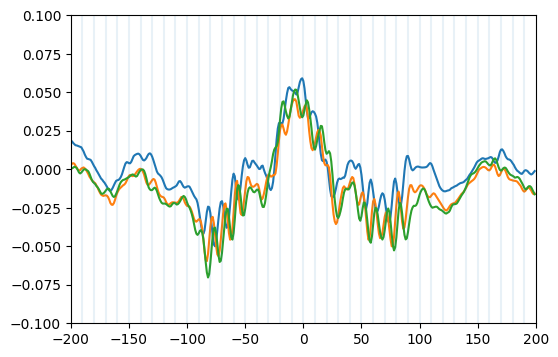

In [287]:
plt.figure(figsize=(6,4))

plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.5bp_C26"], label="Predicted C26")
plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.5bp_C29"], label="Predicted C29")
plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.5bp_C31"], label="Predicted C31")

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C26_rev_comp"], label="Predicted C26",
#          color="C0", linestyle="dashed")
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C29_rev_comp"], label="Predicted C29",
#          color="C1", linestyle="dashed")
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C31_rev_comp"], label="Predicted C31",
#          color="C2", linestyle="dashed")


# plt.plot(genome_df_chrV_dist_nuc_grouped["smoothC0"], label="SmoothC0", color="C3")

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C03"], label="Predicted C0 (aa3)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_C04"], label="Predicted C0 (aa4)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_cn_mean"], label="Predicted Cn Mean", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_cn_mean2"], label="SmoothC0", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.4bp_cn_mean3"], label="Predicted Cn Mean 3", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1]+1, alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 10.4bp Smoothing")
# plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned2)
plt.show()

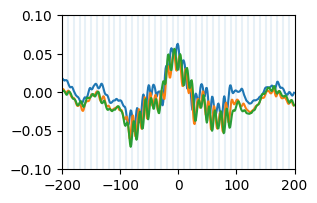

In [73]:
plt.figure(figsize=(3,2))

plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C26"], label="Predicted C26")
plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C29"], label="Predicted C29")
plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C31"], label="Predicted C31")

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C26_rev_comp"], label="Predicted C26", alpha=alpha_val,
#          color="C0", linestyle="dashed")
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C29_rev_comp"], label="Predicted C29", alpha=alpha_val,
#          color="C1", linestyle="dashed")
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C31_rev_comp"], label="Predicted C31", alpha=alpha_val,
#          color="C2", linestyle="dashed")

# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C01"], label="Predicted C0 (aa1)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_cn_mean"], label="Predicted Cn Mean", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped["smooth_10.7bp_cn_mean2"], label="Predicted Cn Mean 2", alpha=alpha_val_aligned)

# plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
# plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

# plt.title("ChrV Aligned at Nucleosome Centers, 10.7bp Smoothing")
# plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned2)
plt.show()

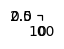

<Figure size 1400x200 with 0 Axes>

In [286]:
x = np.linspace(1, 100, 1000)
y = np.log(x)
y1 = np.sin(x)
fig = plt.figure("Line plot", figsize=(0,0))
legendFig = plt.figure("Legend plot")
ax = fig.add_subplot(111)
line1, = ax.plot(x,y, color="C0")
line2, = ax.plot(x,y, color="C1")
line3, = ax.plot(x,y, color="C2")
# line4, = ax.plot(x,y, color="C0", linestyle="dashdot")
# line5, = ax.plot(x,y, color="C1", linestyle="dashdot")
# line6, = ax.plot(x,y, color="C2", linestyle="dashdot")
# line7, = ax.plot(x,y, color="C3")
# line8, = ax.plot(x,y, color="white")
# line1, = ax.plot(x, y, c="red", lw=4, linestyle="dashdot")
# line2, = ax.plot(x, y1, c="green", lw=1, linestyle="--")
# legendFig.legend([line1, line4, line2, line5, line3, line6], 
#                  ["C26", "C26 Reverse Complement",
#                   "C29", "C29 Reverse Complement",
#                   "C31", "C31 Reverse Complement"], ncol=3)
legendFig.legend([line1, line2, line3], 
                 ["Smooth C26", "Smooth C29", "Smooth C31"], ncols=1)
legendFig.set_figheight(2)
legendFig.set_figwidth(14)
legendFig.savefig('legend.png')

In [70]:
ylims_detrended = [-1.25, 1.1]

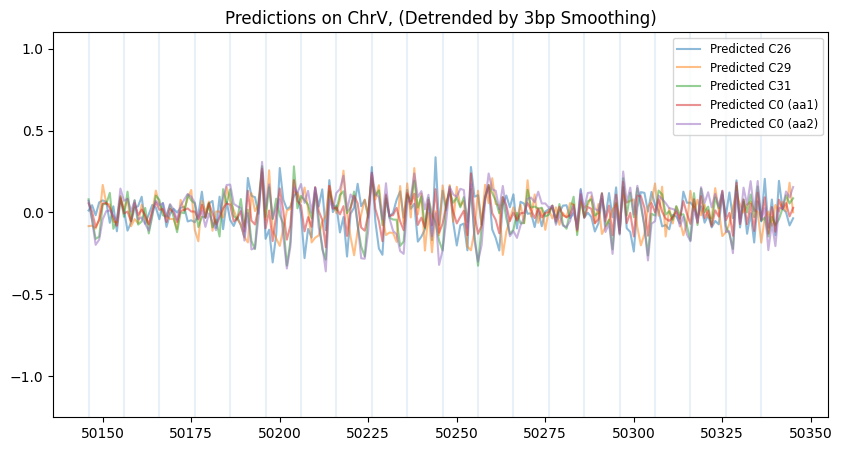

In [78]:
plt.figure(figsize=(10,5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_3bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_3bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_3bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_3bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_3bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on ChrV, (Detrended by 3bp Smoothing)")
plt.legend(fontsize="small")
plt.ylim(ylims_detrended)
plt.show()

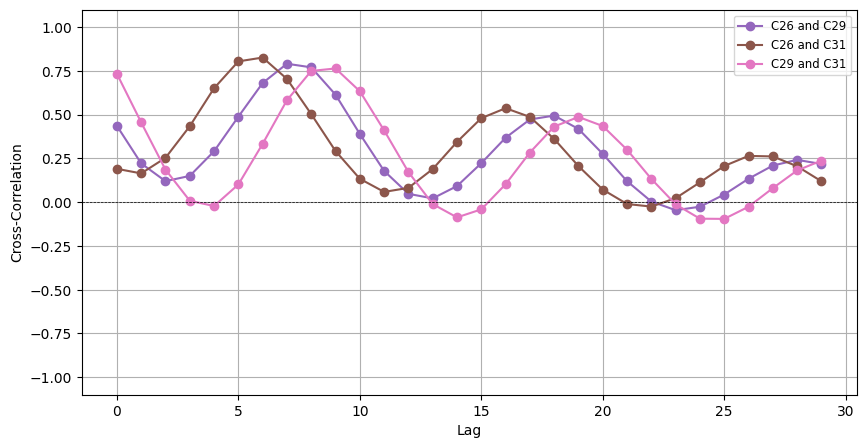

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.ccf(genome_df_chrV["n=26"], genome_df_chrV["n=29"], nlags=30), 
         marker='o', linestyle='-', label="C26 and C29", color="C4")
plt.plot(sm.tsa.ccf(genome_df_chrV["n=26"], genome_df_chrV["n=31"], nlags=30), 
         marker='o', linestyle='-', label="C26 and C31", color="C5")
plt.plot(sm.tsa.ccf(genome_df_chrV["n=29"], genome_df_chrV["n=31"], nlags=30), 
         marker='o', linestyle='-', label="C29 and C31", color="C6")

plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
# plt.title('Cross Correlation Functions, ChrV')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()
# plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C26"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
#          marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)

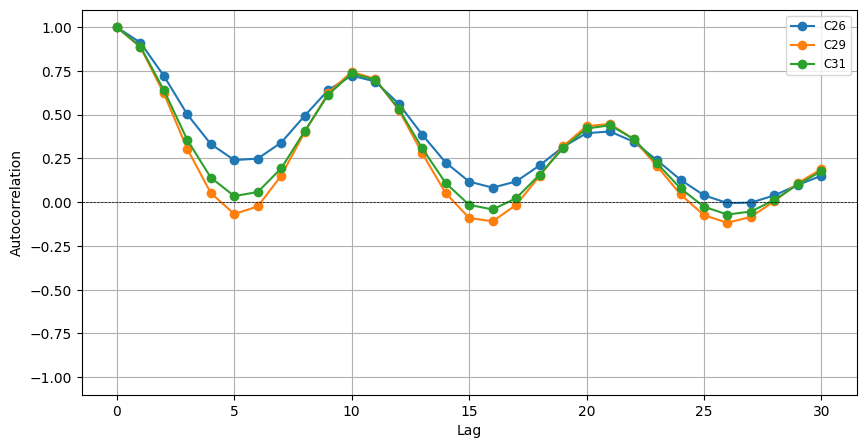

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(genome_df_chrV["n=26"], nlags=30), 
         marker='o', linestyle='-', label="C26", color="C0")
plt.plot(sm.tsa.acf(genome_df_chrV["n=29"], nlags=30), 
         marker='o', linestyle='-', label="C29", color="C1")
plt.plot(sm.tsa.acf(genome_df_chrV["n=31"], nlags=30), 
         marker='o', linestyle='-', label="C31", color="C2")


plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
# plt.title('Cross Correlation Functions, ChrV')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()
# plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C26"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
#          marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)

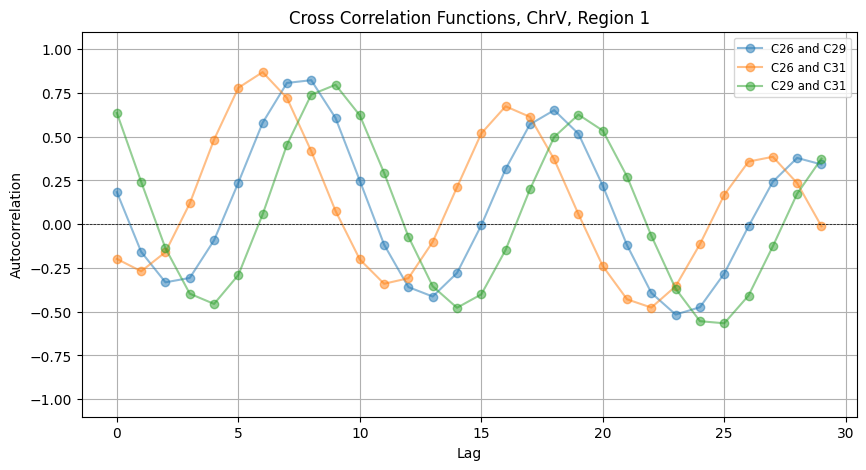

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.ccf(genome_df_chrV["n=26"][range(starting_point1, starting_point1 + sequence_length)], genome_df_chrV["n=29"][range(starting_point1, starting_point1 + sequence_length)], nlags=30), 
         marker='o', linestyle='-', label="C26 and C29", alpha=alpha_val)
plt.plot(sm.tsa.ccf(genome_df_chrV["n=26"][range(starting_point1, starting_point1 + sequence_length)], genome_df_chrV["n=31"][range(starting_point1, starting_point1 + sequence_length)], nlags=30), 
         marker='o', linestyle='-', label="C26 and C31", alpha=alpha_val)
plt.plot(sm.tsa.ccf(genome_df_chrV["n=29"][range(starting_point1, starting_point1 + sequence_length)], genome_df_chrV["n=31"][range(starting_point1, starting_point1 + sequence_length)], nlags=30), 
         marker='o', linestyle='-', label="C29 and C31", alpha=alpha_val)


plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Cross Correlation Functions, ChrV, Region 1')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()
# plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C26"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
#          marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)

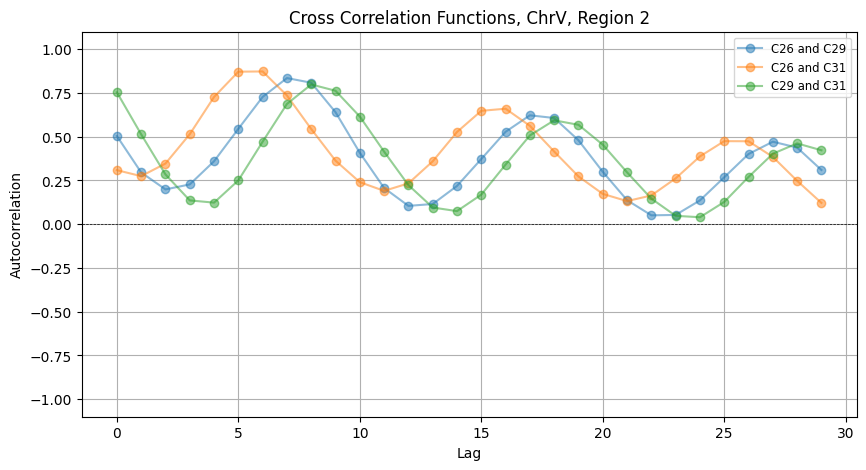

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.ccf(genome_df_chrV["n=26"][range(starting_point2, starting_point2 + sequence_length)], genome_df_chrV["n=29"][range(starting_point2, starting_point2 + sequence_length)], nlags=30), 
         marker='o', linestyle='-', label="C26 and C29", alpha=alpha_val)
plt.plot(sm.tsa.ccf(genome_df_chrV["n=26"][range(starting_point2, starting_point2 + sequence_length)], genome_df_chrV["n=31"][range(starting_point2, starting_point2 + sequence_length)], nlags=30), 
         marker='o', linestyle='-', label="C26 and C31", alpha=alpha_val)
plt.plot(sm.tsa.ccf(genome_df_chrV["n=29"][range(starting_point2, starting_point2 + sequence_length)], genome_df_chrV["n=31"][range(starting_point2, starting_point2 + sequence_length)], nlags=30), 
         marker='o', linestyle='-', label="C29 and C31", alpha=alpha_val)


plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Cross Correlation Functions, ChrV, Region 2')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()
# plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C26"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
#          marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)

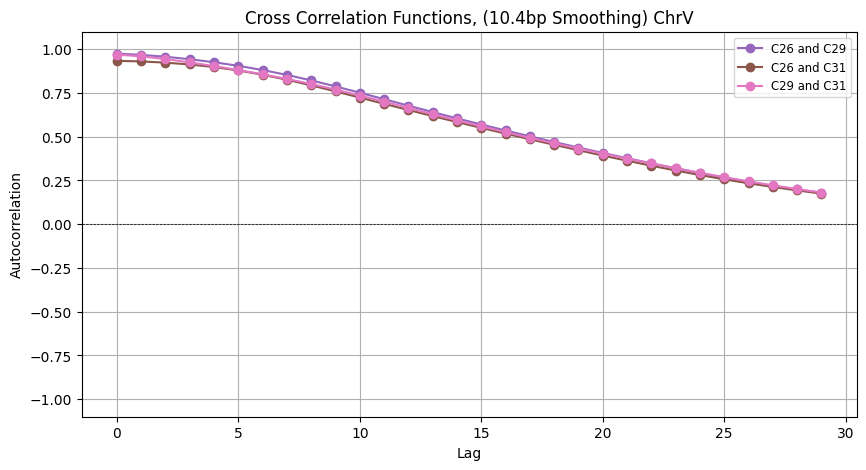

In [176]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.ccf(genome_df_chrV["smooth_10.4bp_C26"][range(5, smooth_cn_df.shape[0]-5)], genome_df_chrV["smooth_10.4bp_C29"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="C26 and C29", color="C4")
plt.plot(sm.tsa.ccf(genome_df_chrV["smooth_10.4bp_C26"][range(5, smooth_cn_df.shape[0]-5)], genome_df_chrV["smooth_10.4bp_C31"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="C26 and C31", color="C5")
plt.plot(sm.tsa.ccf(genome_df_chrV["smooth_10.4bp_C29"][range(5, smooth_cn_df.shape[0]-5)], genome_df_chrV["smooth_10.4bp_C31"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="C29 and C31", color="C6")


plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Cross Correlation Functions, (10.4bp Smoothing) ChrV')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()
# plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C26"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
#          marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)

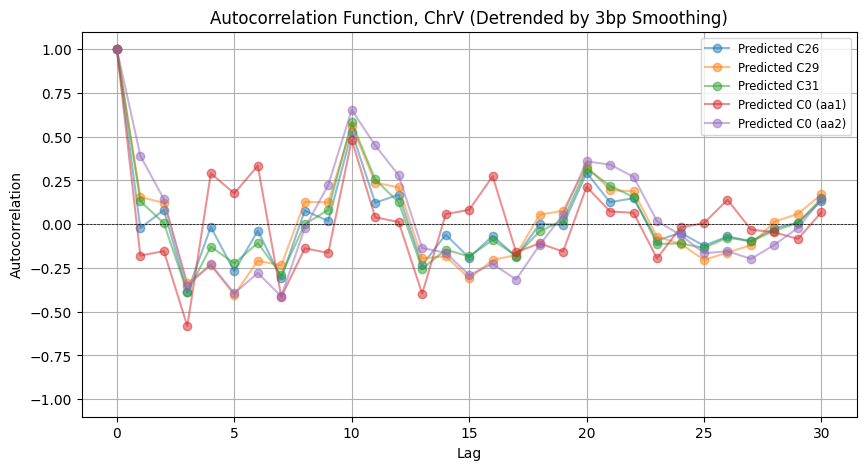

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C26"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C29"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C29", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C31"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C31", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C01"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_3bp_C02"][range(1, smooth_cn_df.shape[0]-1)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa2)", alpha=alpha_val)
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Autocorrelation Function, ChrV (Detrended by 3bp Smoothing)')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

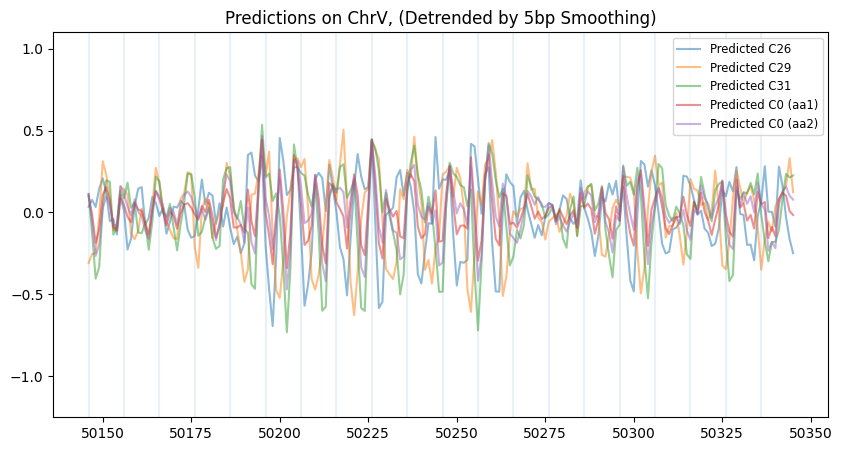

In [80]:
plt.figure(figsize=(10,5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_5bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_5bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_5bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_5bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_5bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on ChrV, (Detrended by 5bp Smoothing)")
plt.legend(fontsize="small")
plt.ylim(ylims_detrended)
plt.show()

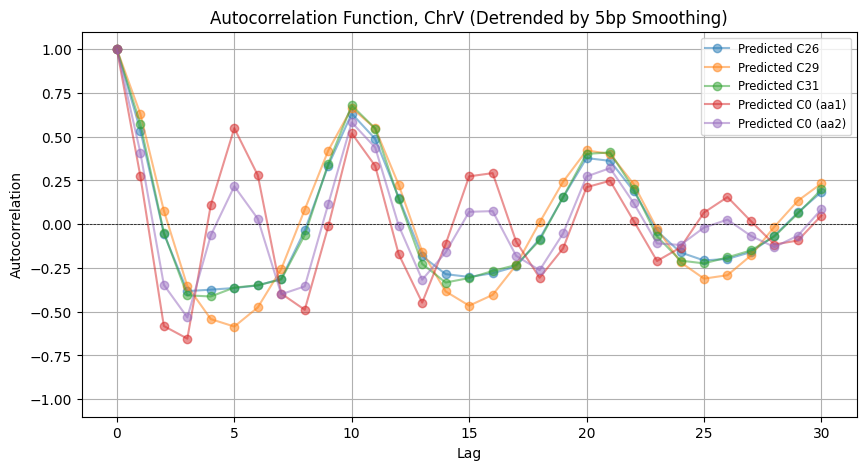

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_5bp_C26"][range(2, smooth_cn_df.shape[0]-2)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_5bp_C29"][range(2, smooth_cn_df.shape[0]-2)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C29", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_5bp_C31"][range(2, smooth_cn_df.shape[0]-2)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C31", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_5bp_C01"][range(2, smooth_cn_df.shape[0]-2)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_5bp_C02"][range(2, smooth_cn_df.shape[0]-2)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa2)", alpha=alpha_val)
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Autocorrelation Function, ChrV (Detrended by 5bp Smoothing)')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

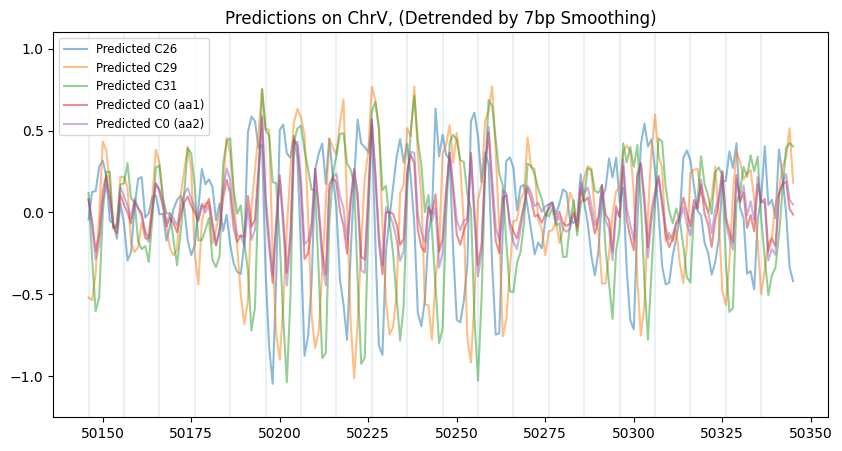

In [82]:
plt.figure(figsize=(10,5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_7bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_7bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_7bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_7bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_7bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on ChrV, (Detrended by 7bp Smoothing)")
plt.legend(fontsize="small")
plt.ylim(ylims_detrended)
plt.show()

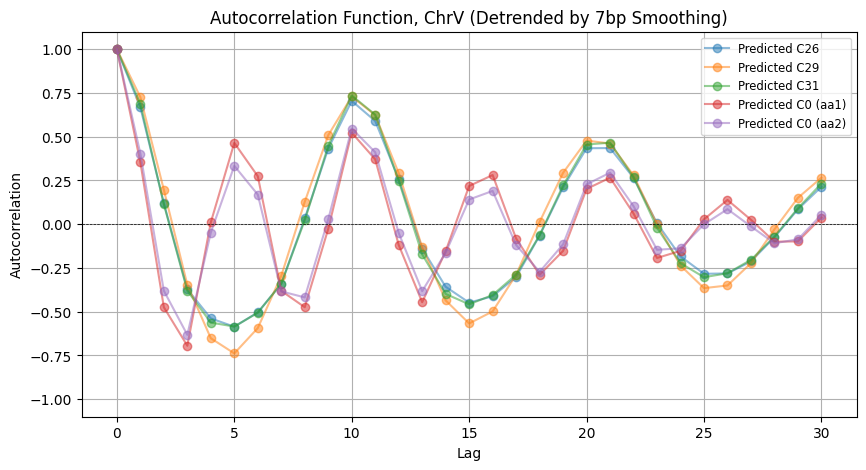

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_7bp_C26"][range(3, smooth_cn_df.shape[0]-3)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_7bp_C29"][range(3, smooth_cn_df.shape[0]-3)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C29", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_7bp_C31"][range(3, smooth_cn_df.shape[0]-3)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C31", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_7bp_C01"][range(3, smooth_cn_df.shape[0]-3)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_7bp_C02"][range(3, smooth_cn_df.shape[0]-3)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa2)", alpha=alpha_val)
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Autocorrelation Function, ChrV (Detrended by 7bp Smoothing)')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

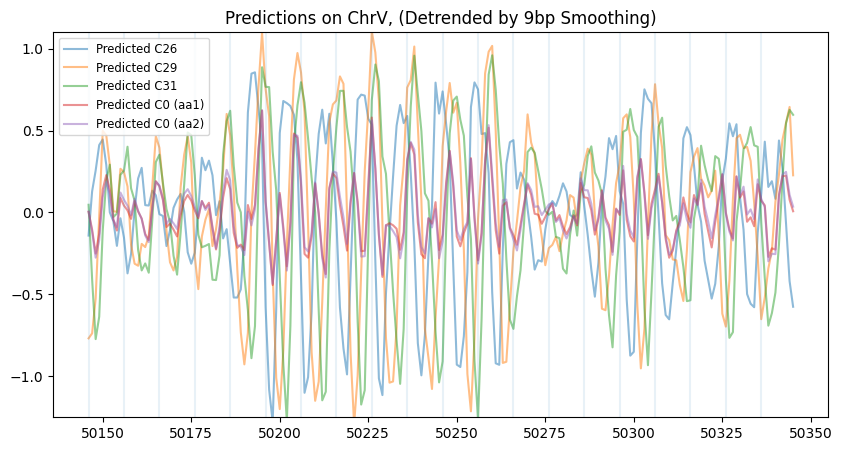

In [84]:
plt.figure(figsize=(10,5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_9bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_9bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_9bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_9bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_9bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on ChrV, (Detrended by 9bp Smoothing)")
plt.legend(fontsize="small")
plt.ylim(ylims_detrended)
plt.show()

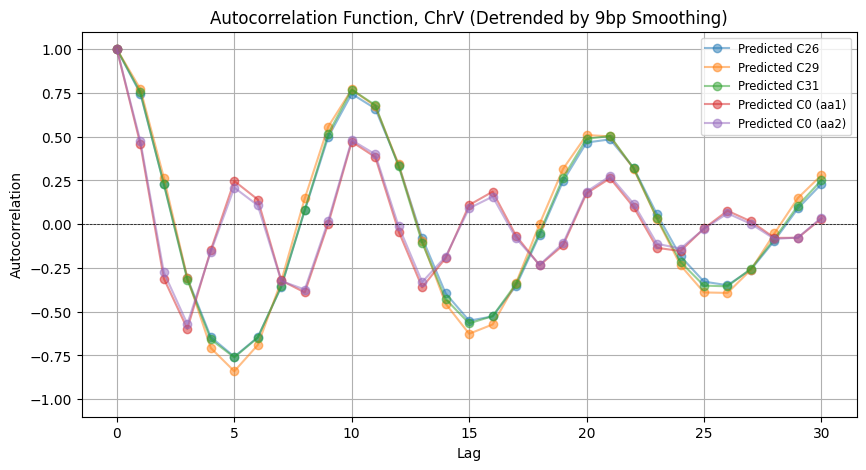

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_9bp_C26"][range(4, smooth_cn_df.shape[0]-4)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_9bp_C29"][range(4, smooth_cn_df.shape[0]-4)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C29", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_9bp_C31"][range(4, smooth_cn_df.shape[0]-4)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C31", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_9bp_C01"][range(4, smooth_cn_df.shape[0]-4)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_9bp_C02"][range(4, smooth_cn_df.shape[0]-4)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa2)", alpha=alpha_val)
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Autocorrelation Function, ChrV (Detrended by 9bp Smoothing)')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

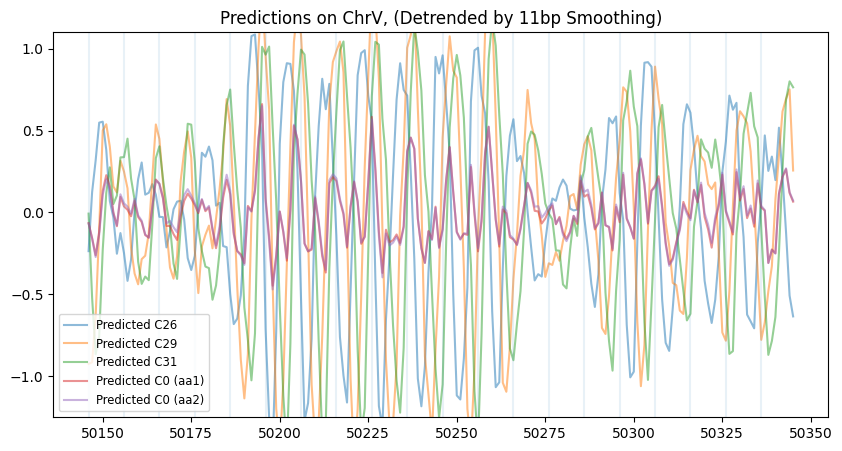

In [86]:
plt.figure(figsize=(10,5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_11bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_11bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_11bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_11bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df["detrended_smooth_11bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on ChrV, (Detrended by 11bp Smoothing)")
plt.legend(fontsize="small")
plt.ylim(ylims_detrended)
plt.show()

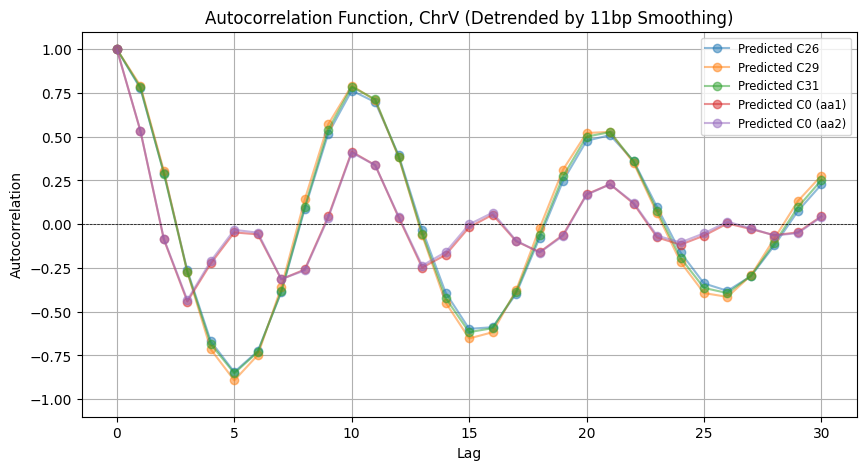

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_11bp_C26"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_11bp_C29"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C29", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_11bp_C31"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C31", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_11bp_C01"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df["detrended_smooth_11bp_C02"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa2)", alpha=alpha_val)
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Autocorrelation Function, ChrV (Detrended by 11bp Smoothing)')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

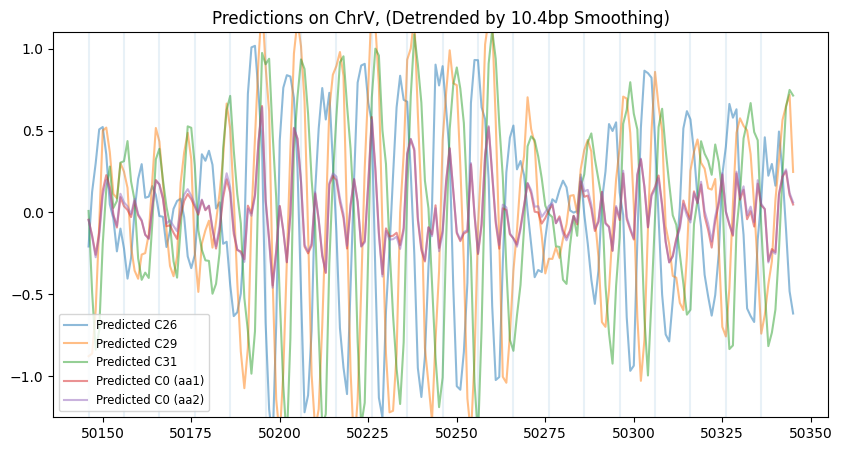

In [88]:
plt.figure(figsize=(10,5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.4bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.4bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.4bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.4bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.4bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on ChrV, (Detrended by 10.4bp Smoothing)")
plt.legend(fontsize="small")
plt.ylim(ylims_detrended)
plt.show()

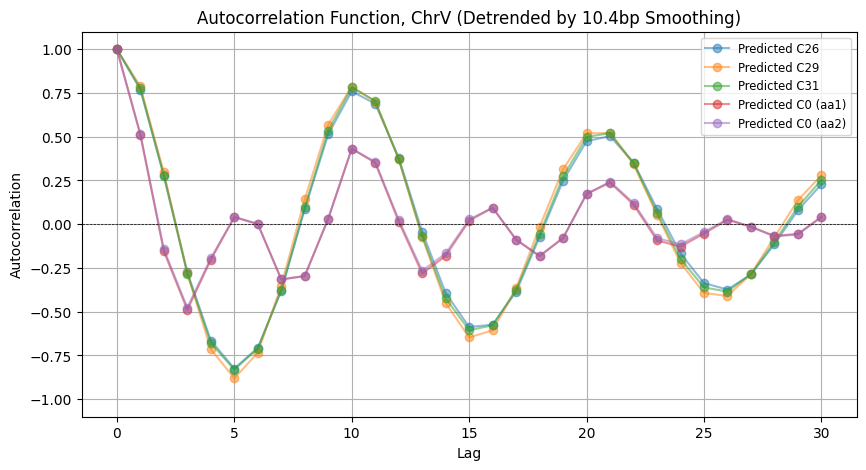

In [89]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.4bp_C26"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.4bp_C29"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C29", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.4bp_C31"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C31", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.4bp_C01"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.4bp_C02"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa2)", alpha=alpha_val)
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Autocorrelation Function, ChrV (Detrended by 10.4bp Smoothing)')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

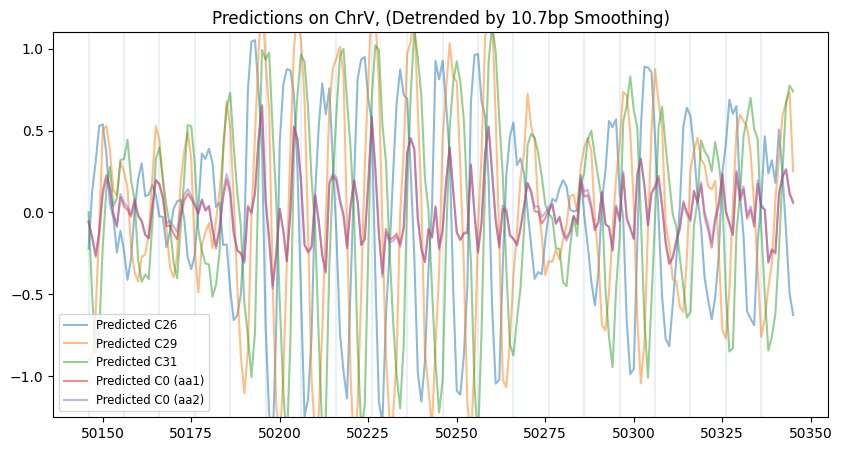

In [90]:
plt.figure(figsize=(10,5))

plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.7bp_C26"][range(starting_point, starting_point + sequence_length)], label="Predicted C26", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.7bp_C29"][range(starting_point, starting_point + sequence_length)], label="Predicted C29", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.7bp_C31"][range(starting_point, starting_point + sequence_length)], label="Predicted C31", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.7bp_C01"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(list(range(starting_point, starting_point + sequence_length)),
         smooth_cn_df_refined["detrended_smooth_10.7bp_C02"][range(starting_point, starting_point + sequence_length)], label="Predicted C0 (aa2)", alpha=alpha_val)

plt.vlines(list(range(starting_point, starting_point+sequence_length, 10)), ylims[0], ylims[1], alpha=0.1)
plt.title("Predictions on ChrV, (Detrended by 10.7bp Smoothing)")
plt.legend(fontsize="small")
plt.ylim(ylims_detrended)
plt.show()

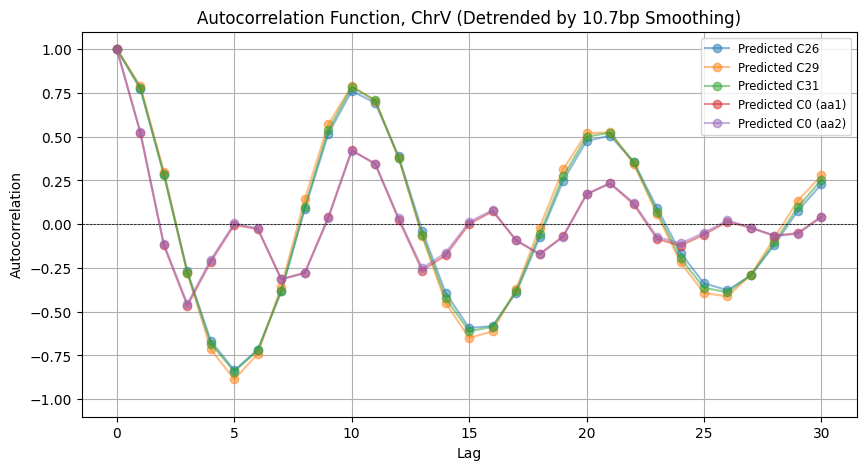

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.7bp_C26"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C26", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.7bp_C29"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C29", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.7bp_C31"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C31", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.7bp_C01"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa1)", alpha=alpha_val)
plt.plot(sm.tsa.acf(smooth_cn_df_refined["detrended_smooth_10.7bp_C02"][range(5, smooth_cn_df.shape[0]-5)], nlags=30), 
         marker='o', linestyle='-', label="Predicted C0 (aa2)", alpha=alpha_val)
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Autocorrelation Function, ChrV (Detrended by 10.7bp Smoothing)')
plt.legend(fontsize="small")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.ylim(-1.1, 1.1)
plt.show()

In [92]:
genome_df_chrV_matched = genome_df_chrV.loc[genome_df_chrV["C26_raw"].notna()].reset_index(drop=True)
genome_df_chrV_matched = genome_df_chrV_matched.loc[genome_df_chrV_matched["smooth_10.4bp_C26"].notna()].reset_index(drop=True)

In [93]:
genome_df_chrV_matched = genome_df_chrV_matched[["sequence", "chrID", "position", "n=26", "n=29", "n=31", "C0", "C0_orig", "C26_raw", "C29_raw", "C31_raw", 
                                                 "smooth_3bp_C26", "smooth_3bp_C29", "smooth_3bp_C31", "smooth_3bp_C01", "smooth_3bp_C02",
                                                 "smooth_5bp_C26", "smooth_5bp_C29", "smooth_5bp_C31", "smooth_5bp_C01", "smooth_5bp_C02",
                                                 "smooth_7bp_C26", "smooth_7bp_C29", "smooth_7bp_C31", "smooth_7bp_C01", "smooth_7bp_C02",
                                                 "smooth_9bp_C26", "smooth_9bp_C29", "smooth_9bp_C31", "smooth_9bp_C01", "smooth_9bp_C02",
                                                 "smooth_11bp_C26", "smooth_11bp_C29", "smooth_11bp_C31", "smooth_11bp_C01", "smooth_11bp_C02",
                                                 "smooth_10.4bp_C26", "smooth_10.4bp_C29", "smooth_10.4bp_C31", "smooth_10.4bp_C01", "smooth_10.4bp_C02", "smooth_10.4bp_cn_mean",
                                                 "smooth_10.7bp_C26", "smooth_10.7bp_C29", "smooth_10.7bp_C31", "smooth_10.7bp_C01", "smooth_10.7bp_C02", "smooth_10.7bp_cn_mean"]]

In [94]:
genome_df_chrV_matched

,sequence,chrID,position,n=26,n=29,n=31,C0,C0_orig,C26_raw,C29_raw,...,smooth_10.4bp_C31,smooth_10.4bp_C01,smooth_10.4bp_C02,smooth_10.4bp_cn_mean,smooth_10.7bp_C26,smooth_10.7bp_C29,smooth_10.7bp_C31,smooth_10.7bp_C01,smooth_10.7bp_C02,smooth_10.7bp_cn_mean
0,TCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACT...,chrV,7,-0.403474,-0.598542,-0.483060,-0.433585,-0.688533,-0.388233,-0.563193,...,-0.400867,-0.397463,-0.396940,-0.400879,-0.397805,-0.398542,-0.394263,-0.395829,-0.396169,-0.396870
1,CCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTACC...,chrV,14,-0.867508,-0.259009,0.205474,-0.325083,-0.464485,-0.947849,0.065416,...,-0.249365,-0.200084,-0.192665,-0.253371,-0.151386,-0.338113,-0.262123,-0.199001,-0.188862,-0.250541
2,TCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTACCTTTATTT...,chrV,21,0.739761,1.151851,0.710244,0.695888,0.383790,0.702216,0.541498,...,0.365271,0.421245,0.430509,0.382724,0.468605,0.282532,0.363817,0.424182,0.433754,0.371651
3,CCCGGATGTTCAACCAAAAGCTACTTACTACCTTTATTTTATGTTT...,chrV,28,1.500665,-0.101892,-0.624371,0.453227,0.122761,0.587374,-0.069926,...,0.433284,0.560126,0.581989,0.495730,0.642398,0.411773,0.461363,0.559518,0.576264,0.505178
4,GTTCAACCAAAAGCTACTTACTACCTTTATTTTATGTTTACTTTTT...,chrV,35,-0.600207,0.762024,1.318497,0.351249,-0.189704,-0.637129,0.534130,...,0.607001,0.500183,0.478285,0.462731,0.405229,0.407919,0.571361,0.495393,0.479543,0.461503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82272,CGTACATGAGGGCTATTTAGGGCTATTTAGGGCTATGTAGAAGTGC...,chrV,576781,3.361288,1.869345,2.071382,2.760539,1.218954,1.691208,0.640780,...,2.489507,2.775831,2.827150,2.682224,3.031859,2.533439,2.504981,2.778984,2.828121,2.690093
82273,GAGGGCTATTTAGGGCTATTTAGGGCTATGTAGAAGTGCTGTAGGG...,chrV,576788,2.490173,2.858421,2.929470,2.704209,1.516590,1.258344,1.652875,...,2.529431,2.815361,2.867317,2.740458,3.093193,2.606471,2.505422,2.806413,2.861389,2.735029
82274,ATTTAGGGCTATTTAGGGCTATGTAGAAGTGCTGTAGGGCTAAAGA...,chrV,576795,3.204474,2.898061,2.573859,2.882222,1.920989,2.016630,2.129109,...,2.451910,2.687479,2.730908,2.642175,2.920659,2.540312,2.459619,2.695616,2.738742,2.640197
82275,GCTATTTAGGGCTATGTAGAAGTGCTGTAGGGCTAAAGAACAGGGT...,chrV,576802,3.222045,1.790789,1.841334,2.567817,1.264983,1.249375,0.327780,...,2.142805,2.347719,2.385692,2.313464,2.522680,2.258527,2.151316,2.338559,2.373395,2.310841


In [95]:
genome_df_chrV_matched.to_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/cycle6_ir_lstm_cn_tiling_post_smoothed_matched.csv", index=False)

In [144]:
genome_df_chrV_to_save = genome_df_chrV[["sequence", "chrID", "position", "n=26", "n=29", "n=31", "C0", "C0_orig", "C26_raw", "C29_raw", "C31_raw", 
                                                 "smooth_3bp_C26", "smooth_3bp_C29", "smooth_3bp_C31", "smooth_3bp_C01", "smooth_3bp_C02",
                                                 "smooth_5bp_C26", "smooth_5bp_C29", "smooth_5bp_C31", "smooth_5bp_C01", "smooth_5bp_C02",
                                                 "smooth_7bp_C26", "smooth_7bp_C29", "smooth_7bp_C31", "smooth_7bp_C01", "smooth_7bp_C02",
                                                 "smooth_9bp_C26", "smooth_9bp_C29", "smooth_9bp_C31", "smooth_9bp_C01", "smooth_9bp_C02",
                                                 "smooth_11bp_C26", "smooth_11bp_C29", "smooth_11bp_C31", "smooth_11bp_C01", "smooth_11bp_C02",
                                                 "smooth_10.4bp_C26", "smooth_10.4bp_C29", "smooth_10.4bp_C31", "smooth_10.4bp_C01", "smooth_10.4bp_C02", "smooth_10.4bp_cn_mean", "smooth_10.4bp_cn_mean2",
                                                 "smooth_10.7bp_C26", "smooth_10.7bp_C29", "smooth_10.7bp_C31", "smooth_10.7bp_C01", "smooth_10.7bp_C02", "smooth_10.7bp_cn_mean", "smooth_10.7bp_cn_mean2"]]

In [145]:
genome_df_chrV_to_save

,sequence,chrID,position,n=26,n=29,n=31,C0,C0_orig,C26_raw,C29_raw,...,smooth_10.4bp_C02,smooth_10.4bp_cn_mean,smooth_10.4bp_cn_mean2,smooth_10.7bp_C26,smooth_10.7bp_C29,smooth_10.7bp_C31,smooth_10.7bp_C01,smooth_10.7bp_C02,smooth_10.7bp_cn_mean,smooth_10.7bp_cn_mean2
0,CGTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAA...,chrV,0,-0.453347,-0.627388,-0.396521,-0.410694,-0.069223,-0.205912,-0.781882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAA...,chrV,1,-0.279821,-0.653612,-0.502821,-0.375857,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAG...,chrV,2,-0.342606,-0.448339,-0.476831,-0.408462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGC...,chrV,3,-0.399345,-0.442532,-0.399097,-0.396295,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCT...,chrV,4,-0.576827,-0.525379,-0.325661,-0.443712,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576820,ATGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTT...,chrV,576820,1.860281,1.425676,0.033508,0.896193,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576821,TGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTT...,chrV,576821,1.728922,1.660969,1.013292,1.344338,0.771321,0.977008,0.887180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576822,GTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTT...,chrV,576822,0.691388,1.564713,1.412105,1.024366,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576823,TAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTTT...,chrV,576823,0.067896,1.451819,1.525671,0.767227,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
genome_df_chrV_to_save.to_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_post_smoothed_matched.csv", index=False)

In [144]:
def dataframe_to_bedgraph(df, filename, colname):
    with open(filename, 'w') as file:
        for index, row in df.iterrows():
            # file.write(f"{row['chrID']}\t{row['start']}\t{row['end']}\t{row[colname]}\n")
            file.write(f"{row['chrID']}\t{row['position']+25}\t{row['position']+25}\t{row[colname]}\n")

In [145]:
genome_df_chrV_to_bedgraph = genome_df_chrV_to_save.fillna(0)

In [146]:
genome_df_chrV_to_bedgraph

,sequence,chrID,position,n=26,n=29,n=31,C0,C0_orig,C26_raw,C29_raw,...,smooth_10.4bp_C02,smooth_10.4bp_cn_mean,smooth_10.4bp_cn_mean2,smooth_10.7bp_C26,smooth_10.7bp_C29,smooth_10.7bp_C31,smooth_10.7bp_C01,smooth_10.7bp_C02,smooth_10.7bp_cn_mean,smooth_10.7bp_cn_mean2
0,CGTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAA...,chrV,0,-0.453347,-0.627388,-0.396521,-0.410694,-0.069223,-0.205912,-0.781882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAA...,chrV,1,-0.279821,-0.653612,-0.502821,-0.375857,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAG...,chrV,2,-0.342606,-0.448339,-0.476831,-0.408462,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGC...,chrV,3,-0.399345,-0.442532,-0.399097,-0.396295,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCT...,chrV,4,-0.576827,-0.525379,-0.325661,-0.443712,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576815,ATGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTT...,chrV,576815,1.860281,1.425676,0.033508,0.896193,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576816,TGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTT...,chrV,576816,1.728922,1.660969,1.013292,1.344338,0.771321,0.977008,0.887180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576817,GTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTT...,chrV,576817,0.691388,1.564713,1.412105,1.024366,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576818,TAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTTT...,chrV,576818,0.067896,1.451819,1.525671,0.767227,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
genome_df_chrV_to_bedgraph["start"] = range(1,genome_df_chrV_to_bedgraph.shape[0]+1)
genome_df_chrV_to_bedgraph["end"] = range(50,genome_df_chrV_to_bedgraph.shape[0]+50)



In [148]:
genome_df_chrV_to_bedgraph

,sequence,chrID,position,n=26,n=29,n=31,C0,C0_orig,C26_raw,C29_raw,...,smooth_10.4bp_cn_mean2,smooth_10.7bp_C26,smooth_10.7bp_C29,smooth_10.7bp_C31,smooth_10.7bp_C01,smooth_10.7bp_C02,smooth_10.7bp_cn_mean,smooth_10.7bp_cn_mean2,start,end
0,CGTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAA...,chrV,0,-0.453347,-0.627388,-0.396521,-0.410694,-0.069223,-0.205912,-0.781882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,50
1,GTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAA...,chrV,1,-0.279821,-0.653612,-0.502821,-0.375857,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,51
2,TCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAG...,chrV,2,-0.342606,-0.448339,-0.476831,-0.408462,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,52
3,CTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGC...,chrV,3,-0.399345,-0.442532,-0.399097,-0.396295,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,53
4,TCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCT...,chrV,4,-0.576827,-0.525379,-0.325661,-0.443712,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576815,ATGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTT...,chrV,576815,1.860281,1.425676,0.033508,0.896193,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,576816,576865
576816,TGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTT...,chrV,576816,1.728922,1.660969,1.013292,1.344338,0.771321,0.977008,0.887180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,576817,576866
576817,GTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTT...,chrV,576817,0.691388,1.564713,1.412105,1.024366,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,576818,576867
576818,TAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTTT...,chrV,576818,0.067896,1.451819,1.525671,0.767227,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,576819,576868


In [149]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph, 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_smooth_104bp_C26.bedgraph",
                      "smooth_10.4bp_C26")

In [150]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph, 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_smooth_104bp_C29.bedgraph",
                      "smooth_10.4bp_C29")

In [151]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph, 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_smooth_104bp_C31.bedgraph",
                      "smooth_10.4bp_C31")

In [152]:
genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"] = genome_df_chrV_to_bedgraph["smooth_10.4bp_C26"] - genome_df_chrV_to_bedgraph["smooth_10.4bp_C31"]

In [153]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph, 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_smooth_104bp_C26_C31_diff.bedgraph",
                      "smooth_10.4bp_C26_C31_diff")

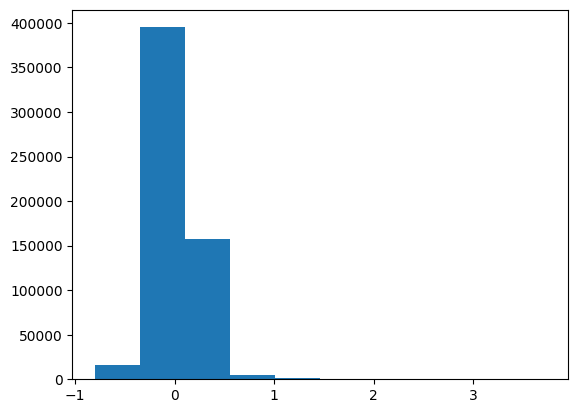

In [154]:
plt.hist(genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"])
plt.show()

In [155]:
# diff_limit = genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"].mean() + 4*genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"].std()
diff_limit = genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"].mean() + 3*genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"].std()
diff_limit

0.744129208414413

In [156]:
sum(genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"] > diff_limit)

4740

In [157]:
genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff_indicator"] = (genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"] > diff_limit).astype(int)

In [158]:
max(genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff"])

3.7296127040097202

In [159]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph, 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_smooth_104bp_C26_C31_diff_indicator.bedgraph",
                      "smooth_10.4bp_C26_C31_diff_indicator")

In [160]:
genome_df_chrV_to_bedgraph.tail()

,sequence,chrID,position,n=26,n=29,n=31,C0,C0_orig,C26_raw,C29_raw,...,smooth_10.7bp_C29,smooth_10.7bp_C31,smooth_10.7bp_C01,smooth_10.7bp_C02,smooth_10.7bp_cn_mean,smooth_10.7bp_cn_mean2,start,end,smooth_10.4bp_C26_C31_diff,smooth_10.4bp_C26_C31_diff_indicator
576815,ATGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTT...,chrV,576815,1.860281,1.425676,0.033508,0.896193,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,576816,576865,0.0,0
576816,TGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTT...,chrV,576816,1.728922,1.660969,1.013292,1.344338,0.771321,0.977008,0.88718,...,0.0,0.0,0.0,0.0,0.0,0.0,576817,576866,0.0,0
576817,GTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTT...,chrV,576817,0.691388,1.564713,1.412105,1.024366,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,576818,576867,0.0,0
576818,TAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTTT...,chrV,576818,0.067896,1.451819,1.525671,0.767227,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,576819,576868,0.0,0
576819,AGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTTTT...,chrV,576819,-0.928453,0.753477,1.082689,0.051690,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,576820,576869,0.0,0


In [161]:
genome_df_chrV_exclude_highdiff_regions = genome_df_chrV_to_bedgraph.loc[genome_df_chrV_to_bedgraph["smooth_10.4bp_C26_C31_diff_indicator"] == 0]

In [162]:
genome_df_chrV_exclude_highdiff_regions

,sequence,chrID,position,n=26,n=29,n=31,C0,C0_orig,C26_raw,C29_raw,...,smooth_10.7bp_C29,smooth_10.7bp_C31,smooth_10.7bp_C01,smooth_10.7bp_C02,smooth_10.7bp_cn_mean,smooth_10.7bp_cn_mean2,start,end,smooth_10.4bp_C26_C31_diff,smooth_10.4bp_C26_C31_diff_indicator
0,CGTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAA...,chrV,0,-0.453347,-0.627388,-0.396521,-0.410694,-0.069223,-0.205912,-0.781882,...,0.0,0.0,0.0,0.0,0.0,0.0,1,50,0.0,0
1,GTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAA...,chrV,1,-0.279821,-0.653612,-0.502821,-0.375857,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2,51,0.0,0
2,TCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAG...,chrV,2,-0.342606,-0.448339,-0.476831,-0.408462,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3,52,0.0,0
3,CTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGC...,chrV,3,-0.399345,-0.442532,-0.399097,-0.396295,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,4,53,0.0,0
4,TCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCT...,chrV,4,-0.576827,-0.525379,-0.325661,-0.443712,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,5,54,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576815,ATGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTT...,chrV,576815,1.860281,1.425676,0.033508,0.896193,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,576816,576865,0.0,0
576816,TGTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTT...,chrV,576816,1.728922,1.660969,1.013292,1.344338,0.771321,0.977008,0.887180,...,0.0,0.0,0.0,0.0,0.0,0.0,576817,576866,0.0,0
576817,GTAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTT...,chrV,576817,0.691388,1.564713,1.412105,1.024366,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,576818,576867,0.0,0
576818,TAGAAGTGCTGTAGGGCTAAAGAACAGGGTTTCATTTTCATTTTTT...,chrV,576818,0.067896,1.451819,1.525671,0.767227,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,576819,576868,0.0,0


In [163]:
genome_df_chrV_exclude_highdiff_regions.columns

Index(['sequence', 'chrID', 'position', 'n=26', 'n=29', 'n=31', 'C0',
       'C0_orig', 'C26_raw', 'C29_raw', 'C31_raw', 'smooth_3bp_C26',
       'smooth_3bp_C26', 'smooth_3bp_C29', 'smooth_3bp_C29', 'smooth_3bp_C31',
       'smooth_3bp_C31', 'smooth_3bp_C01', 'smooth_3bp_C02', 'smooth_5bp_C26',
       'smooth_5bp_C26', 'smooth_5bp_C29', 'smooth_5bp_C29', 'smooth_5bp_C31',
       'smooth_5bp_C31', 'smooth_5bp_C01', 'smooth_5bp_C02', 'smooth_7bp_C26',
       'smooth_7bp_C26', 'smooth_7bp_C29', 'smooth_7bp_C29', 'smooth_7bp_C31',
       'smooth_7bp_C31', 'smooth_7bp_C01', 'smooth_7bp_C02', 'smooth_9bp_C26',
       'smooth_9bp_C26', 'smooth_9bp_C29', 'smooth_9bp_C29', 'smooth_9bp_C31',
       'smooth_9bp_C31', 'smooth_9bp_C01', 'smooth_9bp_C02', 'smooth_11bp_C26',
       'smooth_11bp_C26', 'smooth_11bp_C29', 'smooth_11bp_C29',
       'smooth_11bp_C31', 'smooth_11bp_C31', 'smooth_11bp_C01',
       'smooth_11bp_C02', 'smooth_10.4bp_C26', 'smooth_10.4bp_C29',
       'smooth_10.4bp_C31', 'smo

In [164]:
genome_df_chrV_to_bedgraph["pred_C26_resid"] = genome_df_chrV_to_bedgraph["C26_raw"] - genome_df_chrV_to_bedgraph["n=26"]

In [165]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph.loc[genome_df_chrV_to_bedgraph["C26_raw"] != 0], 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_C26_resid.bedgraph",
                      "pred_C26_resid")

In [166]:
genome_df_chrV_to_bedgraph["pred_C29_resid"] = genome_df_chrV_to_bedgraph["C29_raw"] - genome_df_chrV_to_bedgraph["n=29"]

In [167]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph.loc[genome_df_chrV_to_bedgraph["C29_raw"] != 0], 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_C29_resid.bedgraph",
                      "pred_C29_resid")

In [168]:
genome_df_chrV_to_bedgraph["pred_C31_resid"] = genome_df_chrV_to_bedgraph["C31_raw"] - genome_df_chrV_to_bedgraph["n=31"]

In [169]:
dataframe_to_bedgraph(genome_df_chrV_to_bedgraph.loc[genome_df_chrV_to_bedgraph["C31_raw"] != 0], 
                      "/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/chrV_ir_lstm_cn_tiling_C31_resid.bedgraph",
                      "pred_C31_resid")

In [170]:
genome_df_chrV_aligned_exclude_highdiff_regions = pd.read_csv("/Users/Brody1/Dropbox/Northwestern/DNA_Cyclizability/data/Created/yeast_chrV_nucleosome_alignment_window_size200.csv")

In [171]:
genome_df_chrV_aligned_exclude_highdiff_regions["n=26"] = genome_df_chrV.loc[genome_df_chrV_aligned_exclude_highdiff_regions["position"], "n=26"].values
genome_df_chrV_aligned_exclude_highdiff_regions["n=29"] = genome_df_chrV.loc[genome_df_chrV_aligned_exclude_highdiff_regions["position"], "n=29"].values
genome_df_chrV_aligned_exclude_highdiff_regions["n=31"] = genome_df_chrV.loc[genome_df_chrV_aligned_exclude_highdiff_regions["position"], "n=31"].values
genome_df_chrV_aligned_exclude_highdiff_regions["C0"] = genome_df_chrV.loc[genome_df_chrV_aligned_exclude_highdiff_regions["position"], "C0"].values

In [172]:
genome_df_chrV_aligned_exclude_highdiff_regions

,sequence,distance_to_nucleosome,chrID,nucleosome_center,position,n=26,n=29,n=31,C0
0,CCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTT...,-200,chrV,233,8,-0.194927,-0.469367,-0.554537,-0.371961
1,CAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTA...,-199,chrV,233,9,-0.277341,-0.466282,-0.558129,-0.417282
2,AAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTAC...,-198,chrV,233,10,-0.320842,-0.207001,-0.422720,-0.383930
3,AGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACT...,-197,chrV,233,11,-0.424420,-0.134078,-0.229734,-0.338148
4,GCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTA...,-196,chrV,233,12,-0.619899,0.154437,0.097751,-0.281905
...,...,...,...,...,...,...,...,...,...
1276795,AAGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACA...,195,chrV,576551,576721,-0.364871,-0.846146,-0.494482,-0.402864
1276796,AGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAG...,196,chrV,576551,576722,-0.345943,-0.814332,-0.667328,-0.489096
1276797,GGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGG...,197,chrV,576551,576723,-0.175286,-0.645260,-0.808290,-0.487796
1276798,GTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGGG...,198,chrV,576551,576724,-0.220960,-0.203360,-0.572820,-0.413496


In [173]:
# genome_df_chrV_aligned_exclude_highdiff_regions = pd.concat([genome_df_chrV_aligned_exclude_highdiff_regions, smooth_cn_df.loc[genome_df_chrV_aligned["position"]].reset_index()], axis=1)

In [174]:
genome_df_chrV_aligned_exclude_highdiff_regions

,sequence,distance_to_nucleosome,chrID,nucleosome_center,position,n=26,n=29,n=31,C0
0,CCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTT...,-200,chrV,233,8,-0.194927,-0.469367,-0.554537,-0.371961
1,CAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTA...,-199,chrV,233,9,-0.277341,-0.466282,-0.558129,-0.417282
2,AAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTAC...,-198,chrV,233,10,-0.320842,-0.207001,-0.422720,-0.383930
3,AGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACT...,-197,chrV,233,11,-0.424420,-0.134078,-0.229734,-0.338148
4,GCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTA...,-196,chrV,233,12,-0.619899,0.154437,0.097751,-0.281905
...,...,...,...,...,...,...,...,...,...
1276795,AAGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACA...,195,chrV,576551,576721,-0.364871,-0.846146,-0.494482,-0.402864
1276796,AGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAG...,196,chrV,576551,576722,-0.345943,-0.814332,-0.667328,-0.489096
1276797,GGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGG...,197,chrV,576551,576723,-0.175286,-0.645260,-0.808290,-0.487796
1276798,GTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGGG...,198,chrV,576551,576724,-0.220960,-0.203360,-0.572820,-0.413496


In [175]:
genome_df_chrV_aligned_exclude_highdiff_regions = pd.concat([genome_df_chrV_aligned_exclude_highdiff_regions, genome_df_chrV_to_bedgraph.loc[genome_df_chrV_aligned_exclude_highdiff_regions["position"]].reset_index()], axis=1)

In [176]:
genome_df_chrV_aligned_exclude_highdiff_regions = genome_df_chrV_aligned_exclude_highdiff_regions.loc[genome_df_chrV_aligned_exclude_highdiff_regions["smooth_10.4bp_C26_C31_diff_indicator"] == 0]

In [177]:
genome_df_chrV_aligned_exclude_highdiff_regions

,sequence,distance_to_nucleosome,chrID,nucleosome_center,position,n=26,n=29,n=31,C0,index,...,smooth_10.7bp_C02,smooth_10.7bp_cn_mean,smooth_10.7bp_cn_mean2,start,end,smooth_10.4bp_C26_C31_diff,smooth_10.4bp_C26_C31_diff_indicator,pred_C26_resid,pred_C29_resid,pred_C31_resid
0,CCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTT...,-200,chrV,233,8,-0.194927,-0.469367,-0.554537,-0.371961,8,...,-0.397451,-0.377461,-0.386847,9,58,-0.091125,0,0.194927,0.469367,0.554537
1,CAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTA...,-199,chrV,233,9,-0.277341,-0.466282,-0.558129,-0.417282,9,...,-0.398997,-0.365191,-0.379399,10,59,-0.184763,0,0.277341,0.466282,0.558129
2,AAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTAC...,-198,chrV,233,10,-0.320842,-0.207001,-0.422720,-0.383930,10,...,-0.385215,-0.354763,-0.362778,11,60,-0.243944,0,0.320842,0.207001,0.422720
3,AGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACT...,-197,chrV,233,11,-0.424420,-0.134078,-0.229734,-0.338148,11,...,-0.348439,-0.346106,-0.330972,12,61,-0.255290,0,0.424420,0.134078,0.229734
4,GCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTA...,-196,chrV,233,12,-0.619899,0.154437,0.097751,-0.281905,12,...,-0.305134,-0.333539,-0.297475,13,62,-0.197732,0,0.619899,-0.154437,-0.097751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276795,AAGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACA...,195,chrV,576551,576721,-0.364871,-0.846146,-0.494482,-0.402864,576721,...,-0.302191,-0.216817,-0.268545,576722,576771,-0.276594,0,0.364871,0.846146,0.494482
1276796,AGGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAG...,196,chrV,576551,576722,-0.345943,-0.814332,-0.667328,-0.489096,576722,...,-0.353272,-0.283607,-0.323508,576723,576772,-0.242700,0,0.345943,0.814332,0.667328
1276797,GGTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGG...,197,chrV,576551,576723,-0.175286,-0.645260,-0.808290,-0.487796,576723,...,-0.376733,-0.328749,-0.354478,576724,576773,-0.183322,0,0.175286,0.645260,0.808290
1276798,GTAGTAAGTAGCTTTTGGTTGAACATCCGGGTAAGAGACAACAGGG...,198,chrV,576551,576724,-0.220960,-0.203360,-0.572820,-0.413496,576724,...,-0.381533,-0.345985,-0.364221,576725,576774,-0.136293,0,0.220960,0.203360,0.572820


In [178]:
genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions = genome_df_chrV_aligned_exclude_highdiff_regions.groupby("distance_to_nucleosome").mean(numeric_only=True)

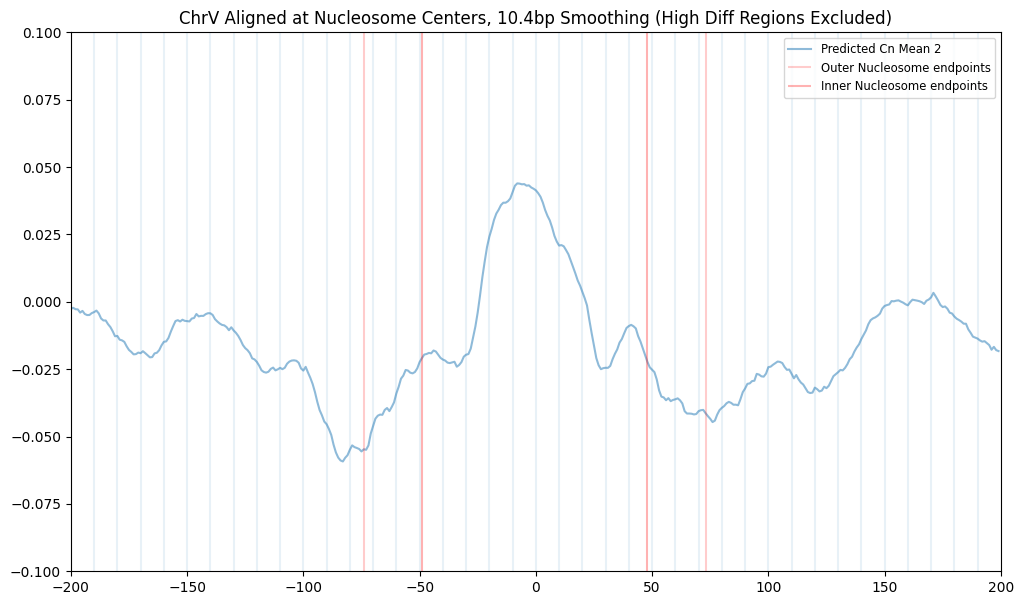

In [179]:
plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)
# # plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C03"], label="Predicted C0 (aa3)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C04"], label="Predicted C0 (aa4)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_cn_mean"], label="Predicted Cn Mean", alpha=alpha_val_aligned)
plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_cn_mean2"], label="Predicted Cn Mean 2", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_cn_mean3"], label="Predicted Cn Mean 3", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

plt.title("ChrV Aligned at Nucleosome Centers, 10.4bp Smoothing (High Diff Regions Excluded)")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.ylim(ylims_aligned2)
plt.show()

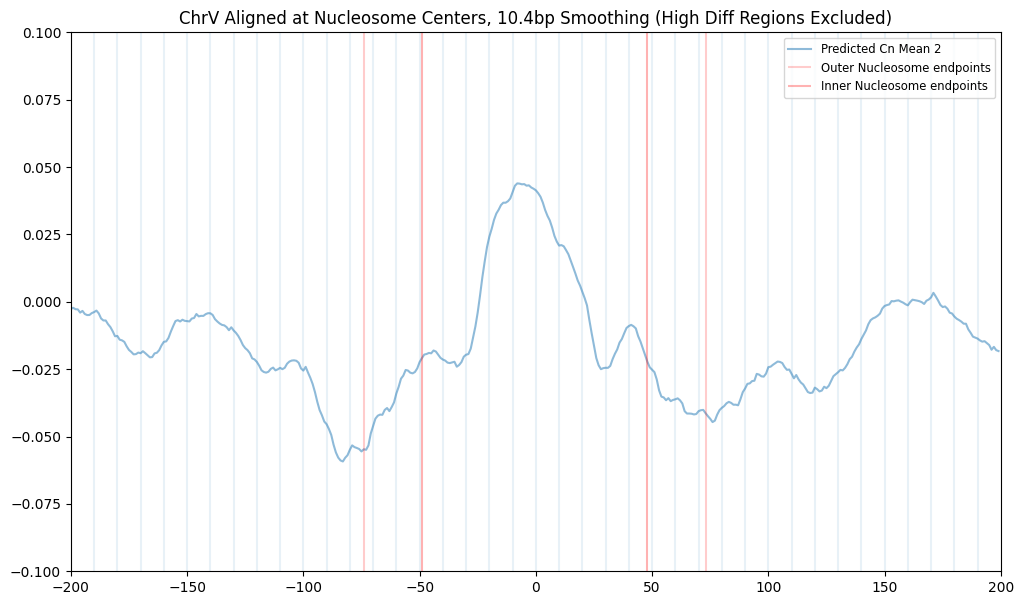

In [182]:
plt.figure(figsize=(12,7))

# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C26"], label="Predicted C26", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C29"], label="Predicted C29", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C31"], label="Predicted C31", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C02"], label="Predicted C0 (aa2)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C03"], label="Predicted C0 (aa3)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_C04"], label="Predicted C0 (aa4)", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_cn_mean"], label="Predicted Cn Mean", alpha=alpha_val_aligned)
plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_cn_mean2"], label="Predicted Cn Mean 2", alpha=alpha_val_aligned)
# plt.plot(genome_df_chrV_dist_nuc_grouped_exclude_highdiff_regions["smooth_10.4bp_cn_mean3"], label="Predicted Cn Mean 3", alpha=alpha_val_aligned)

plt.vlines([-74, 73], ylims[0], ylims[1], color="red", alpha=0.2, label="Outer Nucleosome endpoints")
plt.vlines([-49, 48], ylims[0], ylims[1], color="red", alpha=0.3, label="Inner Nucleosome endpoints")

plt.vlines([i*10 for i in list(range(-20, 20))], ylims[0], ylims[1], alpha=0.1)

plt.title("ChrV Aligned at Nucleosome Centers, 10.4bp Smoothing (High Diff Regions Excluded)")
plt.legend(fontsize="small")
plt.xlim(xlims_aligned)
plt.ylim(ylims_aligned1)
plt.ylim(ylims_aligned2)
plt.show()